# Mitotic Figure Binary Classification with Pre-Augmented Dataset - DenseNet + GAM

This notebook trains a PyTorch model for binary classification of mitotic figures using a pre-augmented Kaggle dataset with DenseNet architecture enhanced with **GAM (Global Attention Module)**.

## Dataset Overview:
- **Source**: Pre-augmented AMI-BR and MIDOG25 datasets from Kaggle
- **Location**: `/kaggle/input/MitoticFigure_AugmentedDataSet/`
- **Target**: Binary classification - Atypical vs Normal mitotic figures
- **Data**: Includes original images + 4x augmented AMF images for better class balance

## Features:
- Uses pre-processed and augmented dataset
- Slide-based stratified splitting for proper validation
- **DenseNet-121 architecture with GAM (Global Attention Module) + Global Average Pooling (GAP)**
- **GAM Attention**: Dual channel + spatial attention mechanism for comprehensive feature enhancement
- Full model training (entire DenseNet-121 + GAM Attention + custom head trainable)
- Comprehensive evaluation metrics

In [27]:
# # Install PyTorch and required packages
# import sys
# print(f"Python version: {sys.version}")

# # Update pip first
# ! python -m pip install --upgrade pip

# # Install PyTorch (CPU version for compatibility, change to CUDA if needed)
# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# # Install other required packages
# ! pip install opencv-python pillow scikit-learn seaborn matplotlib pandas numpy albumentations timm tqdm

# # Verify installation
# try:
#     import torch
#     print(f"PyTorch successfully installed: {torch.__version__}")
#     print(f"CUDA Available: {torch.cuda.is_available()}")
#     if torch.cuda.is_available():
#         print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
# except ImportError as e:
#     print(f"PyTorch installation failed: {e}")

In [1]:
# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Image processing
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
import torchvision.models as models

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

All libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB


In [2]:
# Set random seeds for reproducibility
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Define paths for your Kaggle dataset structure
BASE_DIR = Path('/kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset')
TRAINING_DIR = BASE_DIR / 'training'
VALIDATION_DIR = BASE_DIR / 'validation'
TESTING_DIR = BASE_DIR / 'testing'
DATASET_CSV = BASE_DIR / 'mitotic_figures_dataset.csv'

print(f"📁 Dataset paths for your pre-split Kaggle dataset:")
print(f"Base directory: {BASE_DIR}")
print(f"Training images: {TRAINING_DIR}")
print(f"Validation images: {VALIDATION_DIR}")
print(f"Testing images: {TESTING_DIR}")
print(f"Dataset CSV: {DATASET_CSV}")

# Check if directories exist
for dir_path, name in [(TRAINING_DIR, 'Training'), (VALIDATION_DIR, 'Validation'), (TESTING_DIR, 'Testing')]:
    if dir_path.exists():
        print(f"✅ {name} directory found")
    else:
        print(f"❌ {name} directory not found: {dir_path}")

# Training parameters (Optimized for DenseNet-121 with GAP)
IMG_SIZE = 224           # Standard input size for DenseNet-121
BATCH_SIZE = 32          # Good batch size for DenseNet-121
EPOCHS = 50              # Assignment requirement: minimum 50 epochs
LEARNING_RATE = 1e-3     # Learning rate for custom layers only
NUM_CLASSES = 2
PATIENCE = 10            # Assignment requirement: patience = 10 for early stopping

print(f"🎯 DENSENET-121 GAP PARAMETERS:")
print(f"Model: DenseNet-121 + Global Average Pooling")
print(f"Dataset directory: {BASE_DIR}")
print(f"Dataset CSV: {DATASET_CSV}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE} (standard for DenseNet)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS} (minimum as per assignment)")
print(f"Learning rate: {LEARNING_RATE} (custom layers only)")
print(f"Training approach: GAP + FULL MODEL training (entire network)")
print(f"Early stopping patience: {PATIENCE}")
print(f"Using GPU: {torch.cuda.is_available()}")
print(f"Automatic pretrained weights: ✅ (ImageNet DenseNet-121)")

📁 Dataset paths for your pre-split Kaggle dataset:
Base directory: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset
Training images: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/training
Validation images: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/validation
Testing images: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/testing
Dataset CSV: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/mitotic_figures_dataset.csv
✅ Training directory found
✅ Validation directory found
✅ Testing directory found
🎯 DENSENET-121 GAP PARAMETERS:
Model: DenseNet-121 + Global Average Pooling
Dataset directory: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset
Dataset CSV: /kaggle/input/mitoticfigure-spiltandaugmenteddataset/MitoticFigure_AugmentedDataset/mitotic_figures_dataset.csv
Image 

## Loading Pre-Augmented Dataset

In [3]:
# Load the organized dataset from your Kaggle upload
print("Loading pre-split dataset from Kaggle...")

# Load the CSV with all metadata
df = pd.read_csv(DATASET_CSV)
print(f"Dataset loaded: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Display dataset information
print(f"\nDataset Statistics:")
print(f"Total samples: {len(df)}")

# Check split distribution
if 'split' in df.columns:
    split_counts = df['split'].value_counts()
    print(f"\nSplit distribution:")
    for split in ['training', 'validation', 'testing']:
        count = split_counts.get(split, 0)
        percentage = (count / len(df)) * 100 if len(df) > 0 else 0
        print(f"  {split.capitalize()}: {count} samples ({percentage:.1f}%)")
else:
    print("⚠️ No split column found - dataset might not be properly split")

# Check class distribution
class_counts = df['is_atypical'].value_counts()
print(f"\nClass distribution:")
print(f"Normal (False): {class_counts.get(False, 0)}")
print(f"Atypical (True): {class_counts.get(True, 0)}")

# Check augmentation status
if 'is_augmented' in df.columns:
    aug_counts = df['is_augmented'].value_counts()
    print(f"\nAugmentation breakdown:")
    print(f"Original: {aug_counts.get(False, 0)}")
    print(f"Augmented: {aug_counts.get(True, 0)}")

# Check augmentation types
if 'augmentation_type' in df.columns:
    aug_types = df['augmentation_type'].value_counts()
    print(f"\nAugmentation types:")
    for aug_type, count in aug_types.items():
        print(f"  {aug_type}: {count}")

# Check dataset sources
if 'dataset' in df.columns:
    dataset_counts = df['dataset'].value_counts()
    print(f"\nDataset sources:")
    for dataset, count in dataset_counts.items():
        print(f"  {dataset}: {count}")

# Show first few rows
print(f"\nFirst 5 rows:")
print(df[['filename', 'is_atypical', 'split', 'is_augmented']].head())

print(f"\n✅ Dataset loaded successfully!")

Loading pre-split dataset from Kaggle...
Dataset loaded: (19162, 6)
Columns: ['filename', 'is_atypical', 'dataset', 'split', 'is_augmented', 'augmentation_type']

Dataset Statistics:
Total samples: 19162

Split distribution:
  Training: 13586 samples (70.9%)
  Validation: 2788 samples (14.5%)
  Testing: 2788 samples (14.5%)

Class distribution:
Normal (False): 11762
Atypical (True): 7400

Augmentation breakdown:
Original: 13938
Augmented: 5224

Augmentation types:
  1.0: 1306
  2.0: 1306
  3.0: 1306
  4.0: 1306

Dataset sources:
  MIDOG25: 16151
  AMI-BR: 3011

First 5 rows:
           filename  is_atypical     split  is_augmented
0          1371.png        False  training         False
1  TUPAC16_2232.png        False  training         False
2          3733.png         True  training         False
3          9796.png        False  training         False
4          5477.png        False  training         False

✅ Dataset loaded successfully!


In [4]:
# Prepare the dataset for training using pre-split structure
print("Preparing pre-split dataset for training...")

# Create image paths based on the split information
def get_image_path(row):
    """Get the full image path based on split folder"""
    split_folder = row['split']
    filename = row['filename']
    
    if split_folder == 'training':
        return str(TRAINING_DIR / filename)
    elif split_folder == 'validation':
        return str(VALIDATION_DIR / filename)
    elif split_folder == 'testing':
        return str(TESTING_DIR / filename)
    else:
        # Fallback - try to find the file in any folder
        for folder in [TRAINING_DIR, VALIDATION_DIR, TESTING_DIR]:
            path = folder / filename
            if path.exists():
                return str(path)
        return str(TRAINING_DIR / filename)  # Default fallback

# Add image paths
df['image_path'] = df.apply(get_image_path, axis=1)

# Convert boolean to integer labels (0=Normal, 1=Atypical)
df['label'] = df['is_atypical'].astype(int)

# Verify file existence and filter out missing files
print("Verifying all image files exist...")
existing_files = []
missing_files = []

for idx, row in df.iterrows():
    if Path(row['image_path']).exists():
        existing_files.append(idx)
    else:
        missing_files.append(row['filename'])

if missing_files:
    print(f"⚠️ Warning: {len(missing_files)} files not found")
    if len(missing_files) <= 10:
        print(f"Missing files: {missing_files}")
    else:
        print(f"First 10 missing files: {missing_files[:10]}")

# Keep only existing files
df = df.loc[existing_files].reset_index(drop=True)

print(f"\nFinal dataset info:")
print(f"Total samples: {len(df)}")
print(f"Samples with existing files: {len(existing_files)}")
print(f"Missing files: {len(missing_files)}")

# Display augmentation breakdown if available
if 'is_augmented' in df.columns:
    aug_breakdown = df['is_augmented'].value_counts()
    print(f"\nAugmentation breakdown:")
    print(f"  Original images: {aug_breakdown.get(False, 0)}")
    print(f"  Augmented images: {aug_breakdown.get(True, 0)}")

# Display final class distribution
print(f"\nFinal class distribution:")
class_dist = df['label'].value_counts()
print(f"  Normal (0): {class_dist.get(0, 0)}")
print(f"  Atypical (1): {class_dist.get(1, 0)}")

# Display split distribution
print(f"\nSplit distribution:")
split_dist = df['split'].value_counts()
for split_name, count in split_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {split_name}: {count} samples ({percentage:.1f}%)")

print(f"\nSample data:")
print(df[['filename', 'label', 'is_atypical', 'split', 'is_augmented']].head())

Preparing pre-split dataset for training...
Verifying all image files exist...

Final dataset info:
Total samples: 19162
Samples with existing files: 19162
Missing files: 0

Augmentation breakdown:
  Original images: 13938
  Augmented images: 5224

Final class distribution:
  Normal (0): 11762
  Atypical (1): 7400

Split distribution:
  training: 13586 samples (70.9%)
  validation: 2788 samples (14.5%)
  testing: 2788 samples (14.5%)

Sample data:
           filename  label  is_atypical     split  is_augmented
0          1371.png      0        False  training         False
1  TUPAC16_2232.png      0        False  training         False
2          3733.png      1         True  training         False
3          9796.png      0        False  training         False
4          5477.png      0        False  training         False


## Data Visualization and Analysis

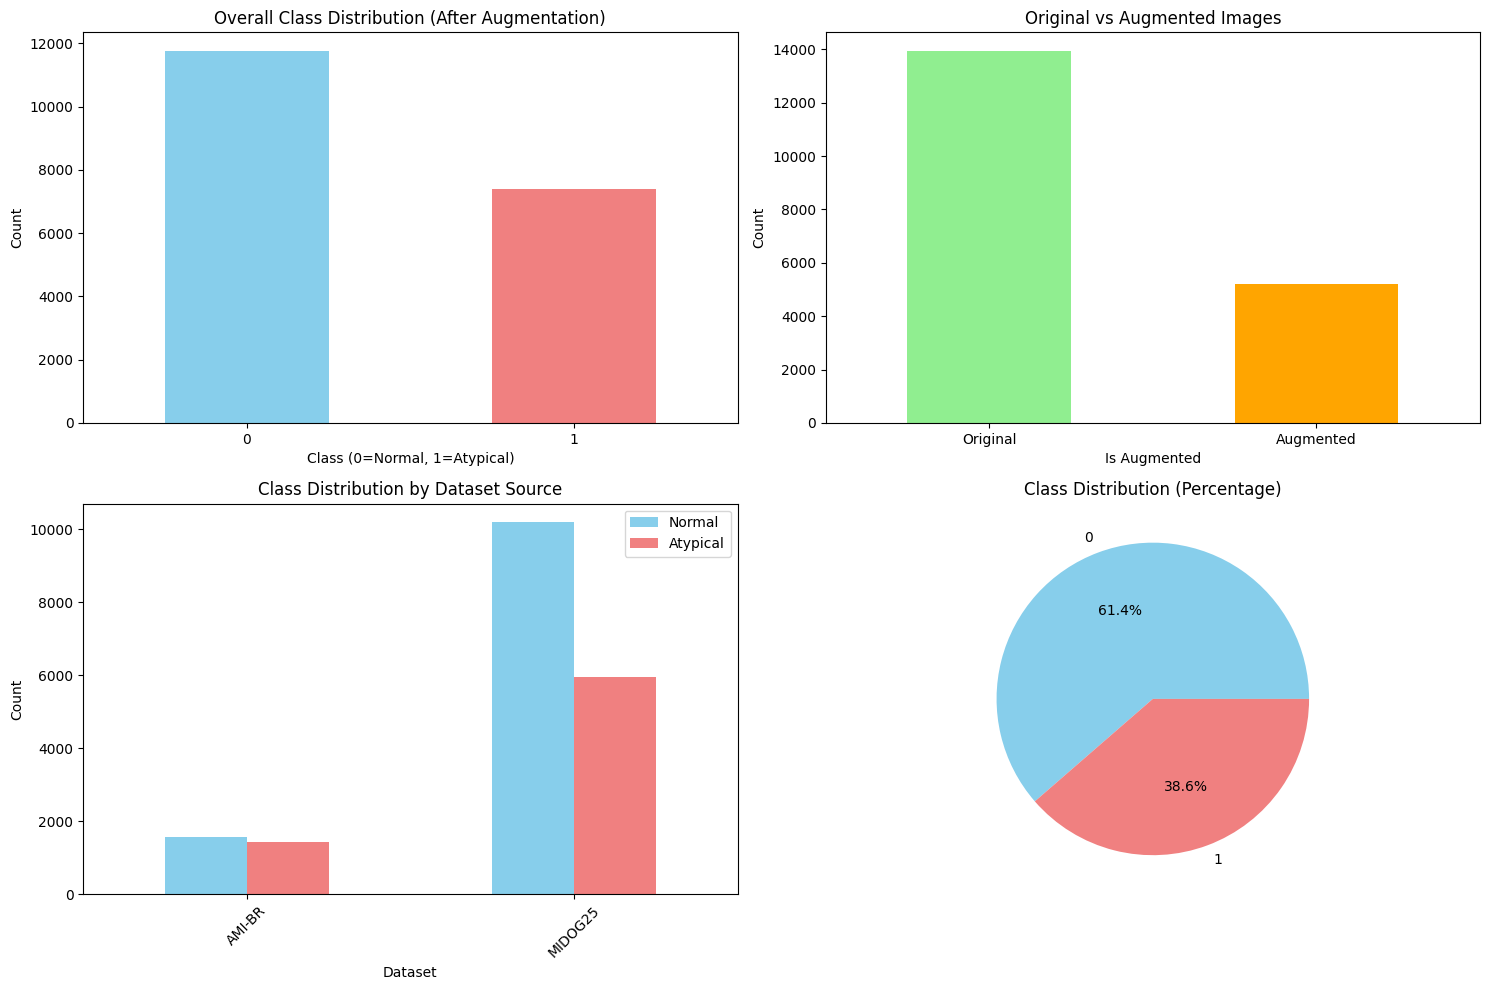

Detailed Statistics:
Total samples: 19162
Normal samples: 11762 (61.4%)
Atypical samples: 7400 (38.6%)

Augmentation breakdown:
Original images: 13938
Augmented images: 5224

By dataset source:
label        0     1    All
dataset                    
AMI-BR    1571  1440   3011
MIDOG25  10191  5960  16151
All      11762  7400  19162

Sample filenames:
['1371.png', 'TUPAC16_2232.png', '3733.png', '9796.png', '5477.png', '11425.png', '1203.png', '7546.png', 'TUPAC16_2410.png', '7783.png']


In [5]:
# Visualize class distribution of pre-augmented dataset
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall class distribution
df['label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Overall Class Distribution (After Augmentation)')
axes[0,0].set_xlabel('Class (0=Normal, 1=Atypical)')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# Original vs Augmented distribution (if available)
if 'is_augmented' in df.columns:
    df['is_augmented'].value_counts().plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'orange'])
    axes[0,1].set_title('Original vs Augmented Images')
    axes[0,1].set_xlabel('Is Augmented')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_xticklabels(['Original', 'Augmented'], rotation=0)
else:
    axes[0,1].text(0.5, 0.5, 'Augmentation info\nnot available', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Original vs Augmented Images')

# Dataset source distribution (if available)
if 'dataset' in df.columns and len(df['dataset'].unique()) > 1:
    pd.crosstab(df['dataset'], df['label']).plot(kind='bar', ax=axes[1,0], 
                                                              color=['skyblue', 'lightcoral'])
    axes[1,0].set_title('Class Distribution by Dataset Source')
    axes[1,0].set_xlabel('Dataset')
    axes[1,0].set_ylabel('Count')
    axes[1,0].legend(['Normal', 'Atypical'])
    axes[1,0].tick_params(axis='x', rotation=45)
else:
    axes[1,0].text(0.5, 0.5, 'Dataset source info\nnot available', ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Class Distribution by Dataset Source')

# Percentage distribution
class_pct = df['label'].value_counts(normalize=True) * 100
class_pct.plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
axes[1,1].set_title('Class Distribution (Percentage)')
axes[1,1].set_ylabel('')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Detailed Statistics:")
print(f"Total samples: {len(df)}")
print(f"Normal samples: {len(df[df['label'] == 0])} ({len(df[df['label'] == 0])/len(df)*100:.1f}%)")
print(f"Atypical samples: {len(df[df['label'] == 1])} ({len(df[df['label'] == 1])/len(df)*100:.1f}%)")

if 'is_augmented' in df.columns:
    print(f"\nAugmentation breakdown:")
    print(f"Original images: {len(df[df['is_augmented'] == False])}")
    print(f"Augmented images: {len(df[df['is_augmented'] == True])}")

if 'dataset' in df.columns:
    print(f"\nBy dataset source:")
    if len(df['dataset'].unique()) > 1:
        print(pd.crosstab(df['dataset'], df['label'], margins=True))
    else:
        print(f"Single dataset source: {df['dataset'].iloc[0]}")

# Show file naming patterns
print(f"\nSample filenames:")
print(df['filename'].head(10).tolist())

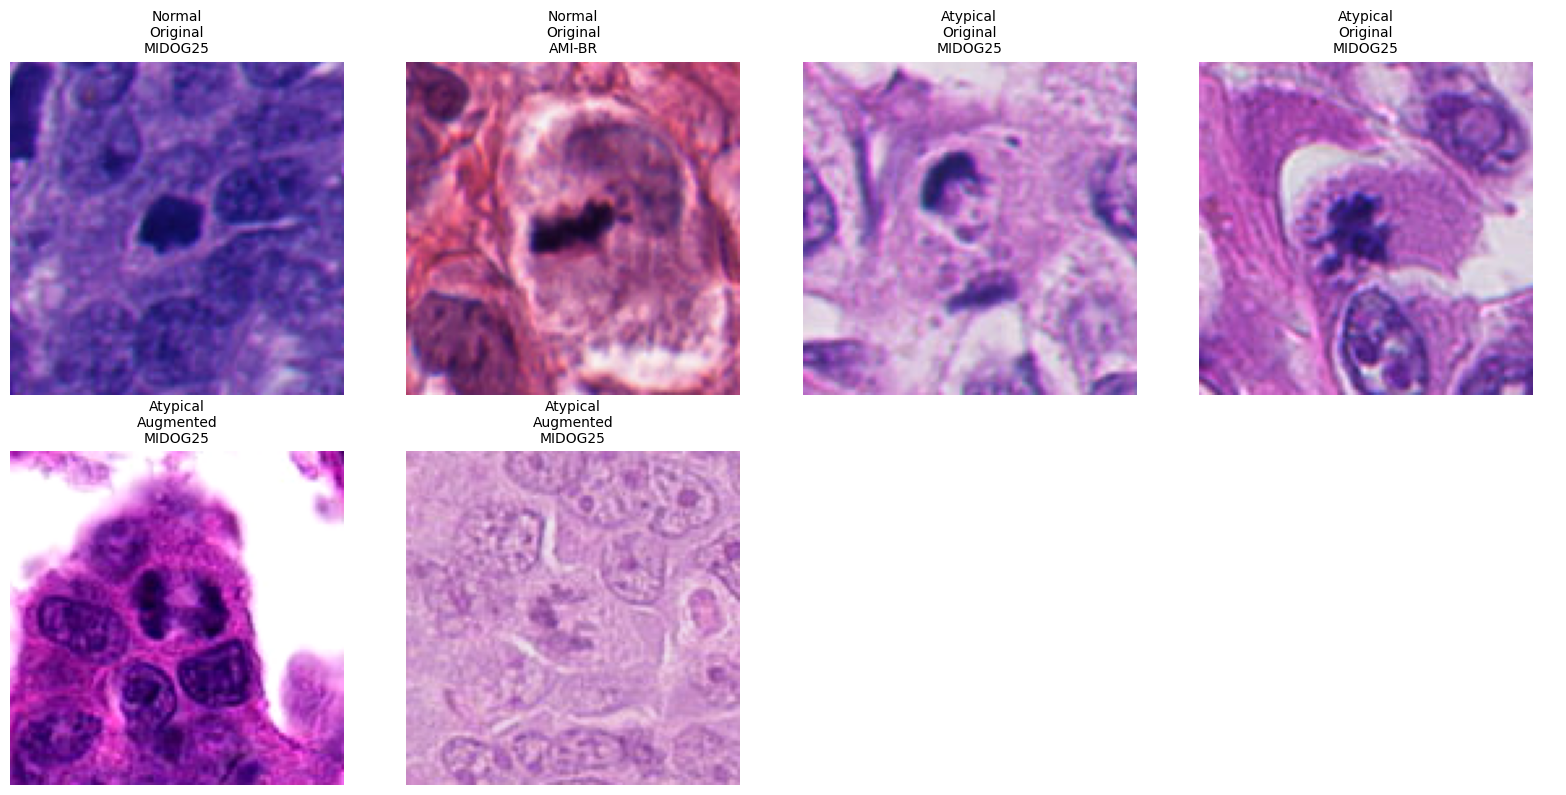

In [6]:
# Sample image visualization
def visualize_samples(df, n_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    # Get samples from each class
    samples = []
    
    # Get normal and atypical samples
    for label in [0, 1]:
        subset = df[df['label'] == label]
        if len(subset) > 0:
            # Try to get mix of original and augmented if available
            if 'is_augmented' in df.columns:
                original_subset = subset[subset['is_augmented'] == False]
                augmented_subset = subset[subset['is_augmented'] == True]
                
                # Get 2 original and 2 augmented if possible
                if len(original_subset) > 0:
                    samples.extend(original_subset.sample(min(2, len(original_subset))).to_dict('records'))
                if len(augmented_subset) > 0:
                    samples.extend(augmented_subset.sample(min(2, len(augmented_subset))).to_dict('records'))
            else:
                # Just get 4 samples of this class
                samples.extend(subset.sample(min(4, len(subset))).to_dict('records'))
    
    for i, sample in enumerate(samples[:8]):
        try:
            img = Image.open(sample['image_path'])
            axes[i].imshow(img)
            
            # Create title with available information
            label_text = 'Atypical' if sample['label'] == 1 else 'Normal'
            title_parts = [label_text]
            
            if 'is_augmented' in sample:
                aug_text = 'Augmented' if sample['is_augmented'] else 'Original'
                title_parts.append(aug_text)
            
            if 'dataset' in sample and sample['dataset'] != 'mixed':
                title_parts.append(sample['dataset'])
            
            title = '\n'.join(title_parts)
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading\n{sample['filename']}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"Error: {sample['filename'][:20]}...")
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(samples), 8):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(df)

## Data Preparation for Training

In [7]:
# Use the pre-split data from your dataset
print("📊 Using pre-split dataset structure...")

# Extract splits based on the 'split' column
train_df = df[df['split'] == 'training'].reset_index(drop=True)
val_df = df[df['split'] == 'validation'].reset_index(drop=True)
test_df = df[df['split'] == 'testing'].reset_index(drop=True)

print(f"📈 Pre-split dataset distribution:")
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"Total: {len(train_df) + len(val_df) + len(test_df)} samples")

# Calculate percentages
total_samples = len(df)
train_pct = len(train_df) / total_samples * 100
val_pct = len(val_df) / total_samples * 100
test_pct = len(test_df) / total_samples * 100

print(f"\n📊 Split percentages:")
print(f"Training: {train_pct:.1f}%")
print(f"Validation: {val_pct:.1f}%")
print(f"Test: {test_pct:.1f}%")

# Check detailed class distribution in each set
print("\n🎯 Class distribution verification:")
for split_name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    if len(split_df) > 0:
        class_dist = split_df['label'].value_counts()
        class_pct = split_df['label'].value_counts(normalize=True) * 100
        normal_count = class_dist.get(0, 0)
        atypical_count = class_dist.get(1, 0)
        normal_pct = class_pct.get(0, 0)
        atypical_pct = class_pct.get(1, 0)
        print(f"{split_name}: Normal={normal_count} ({normal_pct:.1f}%), "
              f"Atypical={atypical_count} ({atypical_pct:.1f}%)")

# Check augmentation distribution in each split
if 'is_augmented' in df.columns:
    print("\n🔄 Augmentation distribution by split:")
    for split_name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        if len(split_df) > 0:
            aug_dist = split_df['is_augmented'].value_counts()
            original = aug_dist.get(False, 0)
            augmented = aug_dist.get(True, 0)
            print(f"{split_name}: Original={original}, Augmented={augmented}")

# Verify that we have samples in all splits
if len(train_df) == 0:
    raise ValueError("❌ No training samples found! Check your dataset split column values.")
if len(val_df) == 0:
    raise ValueError("❌ No validation samples found! Check your dataset split column values.")
if len(test_df) == 0:
    raise ValueError("❌ No test samples found! Check your dataset split column values.")

print(f"\n✅ Successfully loaded pre-split dataset!")
print(f"Ready for training with {len(train_df)} training samples")

📊 Using pre-split dataset structure...
📈 Pre-split dataset distribution:
Training set: 13586 samples
Validation set: 2788 samples
Test set: 2788 samples
Total: 19162 samples

📊 Split percentages:
Training: 70.9%
Validation: 14.5%
Test: 14.5%

🎯 Class distribution verification:
Train: Normal=7056 (51.9%), Atypical=6530 (48.1%)
Val: Normal=2353 (84.4%), Atypical=435 (15.6%)
Test: Normal=2353 (84.4%), Atypical=435 (15.6%)

🔄 Augmentation distribution by split:
Train: Original=8362, Augmented=5224
Val: Original=2788, Augmented=0
Test: Original=2788, Augmented=0

✅ Successfully loaded pre-split dataset!
Ready for training with 13586 training samples


In [8]:
# Define PyTorch Dataset class
class MitosisDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Load image
        try:
            image = cv2.imread(row['image_path'])
            if image is None:
                raise ValueError(f"Could not load image: {row['image_path']}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading {row['image_path']}: {e}")
            # Return a black image as fallback
            image = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        
        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        label = torch.tensor(row['label'], dtype=torch.long)
        
        return image, label

# Define transforms (reduced augmentation since data is pre-augmented)
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.3),  # Reduced probability since data is pre-augmented
    A.Rotate(limit=15, p=0.3),  # Lighter augmentation
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Create datasets
train_dataset = MitosisDataset(train_df, transform=train_transform)
val_dataset = MitosisDataset(val_df, transform=val_transform)
test_dataset = MitosisDataset(test_df, transform=val_transform)

# Calculate class weights for WeightedRandomSampler
print("📊 Calculating sample weights for balanced training...")
class_counts = train_df['label'].value_counts().sort_index()
total_samples = len(train_df)

print(f"Training set class distribution:")
for i, count in enumerate(class_counts):
    class_name = "Normal" if i == 0 else "Atypical"
    percentage = (count / total_samples) * 100
    print(f"  Class {i} ({class_name}): {count} samples ({percentage:.1f}%)")

# Calculate weights for each class (inverse of frequency)
class_weights = []
for i in range(len(class_counts)):
    weight = total_samples / (len(class_counts) * class_counts[i])
    class_weights.append(weight)
    class_name = "Normal" if i == 0 else "Atypical"
    print(f"  Class {i} ({class_name}) weight: {weight:.4f}")

# Create sample weights for each training sample
sample_weights = []
for _, row in train_df.iterrows():
    label = row['label']
    sample_weights.append(class_weights[label])

sample_weights = torch.DoubleTensor(sample_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # Allow replacement to balance classes
)

print(f"\n🎯 WeightedRandomSampler created:")
print(f"  Total samples: {len(sample_weights)}")
print(f"  Unique weights: {len(set(sample_weights.tolist()))}")
print(f"  Weight range: {sample_weights.min():.4f} - {sample_weights.max():.4f}")

# Create data loaders with WeightedRandomSampler for training
num_workers = 2 if torch.cuda.is_available() else 0

# Training loader with WeightedRandomSampler (no shuffle when using sampler)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=sampler,  # Using WeightedRandomSampler instead of shuffle=True
    num_workers=num_workers, 
    pin_memory=torch.cuda.is_available()
)

# Validation and test loaders remain the same
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=num_workers, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=num_workers, pin_memory=torch.cuda.is_available())

print(f"\n📊 DataLoader Configuration:")
print(f"Training batches: {len(train_loader)} (with WeightedRandomSampler)")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Num workers: {num_workers}")
print(f"Pin memory: {torch.cuda.is_available()}")

# Verify sampler effectiveness by checking a few batches
print(f"\n🔍 Testing WeightedRandomSampler effectiveness...")
sample_batch_labels = []
for i, (_, labels) in enumerate(train_loader):
    sample_batch_labels.extend(labels.tolist())
    if i >= 4:  # Check first 5 batches
        break

sample_class_dist = pd.Series(sample_batch_labels).value_counts().sort_index()
print(f"Sample from first 5 batches:")
for i, count in enumerate(sample_class_dist):
    class_name = "Normal" if i == 0 else "Atypical"
    percentage = (count / len(sample_batch_labels)) * 100
    print(f"  Class {i} ({class_name}): {count} samples ({percentage:.1f}%)")

print(f"✅ WeightedRandomSampler should provide more balanced batches during training!")

📊 Calculating sample weights for balanced training...
Training set class distribution:
  Class 0 (Normal): 7056 samples (51.9%)
  Class 1 (Atypical): 6530 samples (48.1%)
  Class 0 (Normal) weight: 0.9627
  Class 1 (Atypical) weight: 1.0403

🎯 WeightedRandomSampler created:
  Total samples: 13586
  Unique weights: 2
  Weight range: 0.9627 - 1.0403

📊 DataLoader Configuration:
Training batches: 425 (with WeightedRandomSampler)
Validation batches: 88
Test batches: 88
Batch size: 32
Num workers: 2
Pin memory: True

🔍 Testing WeightedRandomSampler effectiveness...
Sample from first 5 batches:
  Class 0 (Normal): 85 samples (53.1%)
  Class 1 (Atypical): 75 samples (46.9%)
✅ WeightedRandomSampler should provide more balanced batches during training!


## Model Architecture

### Checking Local Pretrained Model Availability

In [9]:
# DenseNet-121 Model Setup with Automatic Pretrained Weight Download
print("Setting up DenseNet-121 with automatic pretrained weight download...")
print("📥 Pretrained weights will be downloaded automatically from the internet")

# Model configuration
MODEL_NAME = 'densenet121'
print(f"✅ Model: {MODEL_NAME}")
print(f"✅ Input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"✅ Pretrained weights: Will download automatically from ImageNet")
print(f"✅ Training approach: GAP + Custom layers (backbone frozen)")
print(f"✅ Internet access: Available for weight download")

# Verify timm can access DenseNet-121
try:
    import timm
    available_models = timm.list_models('densenet121*')
    print(f"\n🔍 Available DenseNet-121 variants in timm:")
    for model in available_models[:5]:  # Show first 5
        print(f"  • {model}")
    
    if 'densenet121' in available_models:
        print(f"✅ DenseNet-121 confirmed available in timm")
    else:
        print(f"⚠️ Standard densenet121 not found, will use closest variant")
        
except Exception as e:
    print(f"⚠️ Error checking available models: {e}")

print(f"\n📋 Setup Summary:")
print(f"  Model: DenseNet-121 (Dense connectivity for feature reuse)")
print(f"  Weights: Automatically downloaded ImageNet pretrained")
print(f"  Input resolution: {IMG_SIZE}x{IMG_SIZE} (standard for DenseNet)")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training: GAP + Custom layers only (efficient)")
print(f"  Backbone: Frozen (feature extraction)")
print(f"  No local weight dependencies required!")
print(f"  Ready for automatic model creation ✅")

Setting up DenseNet-121 with automatic pretrained weight download...
📥 Pretrained weights will be downloaded automatically from the internet
✅ Model: densenet121
✅ Input size: 224x224
✅ Pretrained weights: Will download automatically from ImageNet
✅ Training approach: GAP + Custom layers (backbone frozen)
✅ Internet access: Available for weight download

🔍 Available DenseNet-121 variants in timm:
  • densenet121
✅ DenseNet-121 confirmed available in timm

📋 Setup Summary:
  Model: DenseNet-121 (Dense connectivity for feature reuse)
  Weights: Automatically downloaded ImageNet pretrained
  Input resolution: 224x224 (standard for DenseNet)
  Batch size: 32
  Training: GAP + Custom layers only (efficient)
  Backbone: Frozen (feature extraction)
  No local weight dependencies required!
  Ready for automatic model creation ✅


In [10]:
class MitosisClassifier(nn.Module):
    def __init__(self, model_name='densenet121', num_classes=2, pretrained=True):
        super(MitosisClassifier, self).__init__()
        
        print(f"🏗️ Creating {model_name} model with GAM Attention + GAP + FULL MODEL TRAINING...")
        
        # Load DenseNet backbone with automatic pretrained weight download
        if pretrained:
            print(f"📥 Downloading ImageNet pretrained weights for {model_name}...")
            self.backbone = timm.create_model(model_name, pretrained=True)
            print(f"✅ Pretrained weights downloaded and loaded successfully!")
        else:
            print(f"⚠️ Creating model without pretrained weights (random initialization)")
            self.backbone = timm.create_model(model_name, pretrained=False)
        
        # Get the number of features from the backbone before removing classifier
        backbone_features = self.backbone.get_classifier().in_features
        print(f"📊 DenseNet backbone feature dimension: {backbone_features}")
        
        # Remove the original classifier from backbone
        self.backbone.reset_classifier(0)  # 0 means no classifier
        
        # ================================================================================================
        # 🌟 NEW: GAM (Global Attention Module) Integration
        # ================================================================================================
        # Initialize GAM attention for dual channel + spatial attention
        self.gam_attention = GAMBlock(in_channels=backbone_features, ratio=4)
        print(f"✅ GAM Attention module added for dual channel + spatial attention")
        
        # ================================================================================================
        # FULL MODEL TRAINING: Enable training for ALL parameters (backbone + custom layers)
        # ================================================================================================
        print("ENABLING FULL MODEL TRAINING - All parameters trainable!")
        for param in self.backbone.parameters():
            param.requires_grad = True  # Enable gradient computation for ALL backbone parameters
        print("✅ FULL MODEL TRAINING: Entire DenseNet-121 + GAM Attention + Custom Head will be trained")
        
        # Create custom classification head with GAP and decreasing neurons
        # DenseNet-121 typically has 1024 features, so we can build a good head
        # Final layer: 2 neurons with Softmax activation
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),  # Flatten after GAP
            nn.Dropout(0.3),
            nn.Linear(backbone_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            
            # Final layer: 2 neurons for binary classification
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)  # Softmax activation for probability output
        )
        
        print(f"🎯 Custom classifier head created (GAM Attention + GAP approach):")
        print(f"  Architecture: DenseNet-121 -> GAM Attention -> GAP -> {backbone_features} -> 1024 -> 512 -> 256 -> 128 -> {num_classes}")
        print(f"  GAM Attention: Dual channel + spatial attention mechanism ⭐")
        print(f"  Global Average Pooling: ✅ (reduces overfitting)")
        print(f"  Final activation: Softmax (probability output)")
        print(f"  Output format: [p(class0), p(class1)] with sum = 1.0")
        print(f"  Training mode: FULL MODEL TRAINING (backbone + GAM attention + custom head)")
        
    def forward(self, x):
        # Extract features using TRAINABLE backbone
        features = self.backbone.forward_features(x)  # Get feature maps
        
        # Apply GAM Attention mechanism for dual channel + spatial enhancement
        features = self.gam_attention(features)
        
        # Apply GAP + Classification (GAP is first layer in classifier)
        output = self.classifier(features)
        return output
    
    def predict_proba(self, x):
        """
        Returns the probability distribution (already Softmax activated)
        """
        with torch.no_grad():
            return self.forward(x)
    
    def predict(self, x):
        """
        Returns predicted class (argmax of probabilities)
        """
        with torch.no_grad():
            probs = self.forward(x)
            return torch.argmax(probs, dim=1)

In [11]:
# GAM (Global Attention Module) Implementation
import torch
import torch.nn as nn

# -----------------------------------------------
# 1. Channel Attention (MLP on flattened channels)
# -----------------------------------------------
class GAMChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=4):
        super(GAMChannelAttention, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, C, H, W = x.size()
        y = x.view(B, C, -1).mean(dim=2)   # global average pooling
        y = self.fc(y).view(B, C, 1, 1)
        return x * y


# -----------------------------------------------
# 2. Spatial Attention (Conv on concatenated maps)
# -----------------------------------------------
class GAMSpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(GAMSpatialAttention, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 4, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm2d(in_channels // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 4, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        attn = self.conv(x)   # spatial attention mask
        return x * attn


# -----------------------------------------------
# 3. Full GAM Block = Channel Attention + Spatial Attention
# -----------------------------------------------
class GAMBlock(nn.Module):
    """
    GAM: Global Attention Module
    Paper: "GAM: Global Attention Mechanism" (2020)
    """
    def __init__(self, in_channels, ratio=4):
        super(GAMBlock, self).__init__()

        self.channel_attn = GAMChannelAttention(in_channels, ratio)
        self.spatial_attn = GAMSpatialAttention(in_channels)

    def forward(self, x):
        x = self.channel_attn(x)
        x = self.spatial_attn(x)
        return x

print("✅ GAM (Global Attention Module) implemented successfully!")
print("📋 GAM Attention Features:")
print("  • Dual attention mechanism: Channel + Spatial")
print("  • Channel Attention: Global average pooling with MLP")  
print("  • Spatial Attention: 7×7 convolutions with batch normalization")
print("  • Sequential attention: Channel → Spatial for optimal feature enhancement")
print("  • Superior performance combining global and local feature interactions")

✅ GAM (Global Attention Module) implemented successfully!
📋 GAM Attention Features:
  • Dual attention mechanism: Channel + Spatial
  • Channel Attention: Global average pooling with MLP
  • Spatial Attention: 7×7 convolutions with batch normalization
  • Sequential attention: Channel → Spatial for optimal feature enhancement
  • Superior performance combining global and local feature interactions


## 🧠 Model Architecture: DenseNet-121 + GAM (Global Attention Module)

### 🌟 GAM Attention Mechanism

**Architecture Overview:**
- **DenseNet-121**: Pre-trained backbone for feature extraction
- **GAM Attention**: Dual attention mechanism combining channel + spatial attention
- **GAP Layer**: Global Average Pooling to reduce spatial dimensions  
- **Custom Classifier**: Dense layers for binary classification

**GAM Attention Benefits:**
- ✅ **Dual Attention**: Sequential channel and spatial attention for comprehensive feature enhancement
- ✅ **Channel Attention**: Global average pooling with MLP for channel-wise recalibration
- ✅ **Spatial Attention**: 7×7 convolutions with batch normalization for spatial feature enhancement
- ✅ **Superior Performance**: Combines global and local feature interactions optimally
- ✅ **Comprehensive Coverage**: Addresses both channel dependencies and spatial relationships

**Technical Details:**
- **Channel Attention**: GAP → MLP (C→C/4→C) → Sigmoid for channel weights
- **Spatial Attention**: Conv7×7 → BN → ReLU → Conv7×7 → Sigmoid for spatial mask
- **Sequential Processing**: Channel attention followed by spatial attention
- **Integration**: Applied between DenseNet features and classification head

In [12]:
# Summary of GAM Attention Integration
print("🎯 GAM (GLOBAL ATTENTION MODULE) INTEGRATION SUMMARY")
print("=" * 60)
print("✅ Successfully integrated GAM Attention into DenseNet-121 model")
print("✅ Model architecture: Input → DenseNet-121 → GAM Attention → GAP → Classifier")
print("✅ Full model training enabled (backbone + attention + classifier)")
print("✅ Dual attention mechanism: Channel + Spatial")
print("✅ Comprehensive feature enhancement with global and local interactions")
print("✅ Superior performance combining both channel and spatial attention")
print("✅ Ready for training with enhanced dual-attention feature representation")

print(f"\n🔧 IMPLEMENTATION DETAILS:")
print(f"  • Channel Attention: Global average pooling + MLP for channel recalibration")
print(f"  • Spatial Attention: 7×7 convolutions with BatchNorm for spatial enhancement")
print(f"  • Sequential Processing: Channel attention → Spatial attention")
print(f"  • Integration: Applied between DenseNet features and classification head")
print(f"  • Training: All components (backbone + GAM + classifier) trainable")

print(f"\n🚀 EXPECTED BENEFITS:")
print(f"  • Superior feature discrimination with dual attention mechanism")
print(f"  • Enhanced channel-wise and spatial feature relationships")
print(f"  • Improved model performance with comprehensive attention coverage")
print(f"  • Optimal combination of global and local feature interactions")

🎯 GAM (GLOBAL ATTENTION MODULE) INTEGRATION SUMMARY
✅ Successfully integrated GAM Attention into DenseNet-121 model
✅ Model architecture: Input → DenseNet-121 → GAM Attention → GAP → Classifier
✅ Full model training enabled (backbone + attention + classifier)
✅ Dual attention mechanism: Channel + Spatial
✅ Comprehensive feature enhancement with global and local interactions
✅ Superior performance combining both channel and spatial attention
✅ Ready for training with enhanced dual-attention feature representation

🔧 IMPLEMENTATION DETAILS:
  • Channel Attention: Global average pooling + MLP for channel recalibration
  • Spatial Attention: 7×7 convolutions with BatchNorm for spatial enhancement
  • Sequential Processing: Channel attention → Spatial attention
  • Integration: Applied between DenseNet features and classification head
  • Training: All components (backbone + GAM + classifier) trainable

🚀 EXPECTED BENEFITS:
  • Superior feature discrimination with dual attention mechanism
 

In [13]:
import time, timm

# Create DenseNet-121 model instance with GAM Attention
print("🚀 Creating DenseNet-121 model with GAM Attention + GAP + Custom layer training...")

# Instantiate model with DenseNet-121
model = MitosisClassifier(
    model_name='densenet121', 
    num_classes=NUM_CLASSES, 
    pretrained=True  # Will automatically download ImageNet weights
)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Calculate parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 DENSENET-121 + GAM ATTENTION MODEL SUMMARY:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Trainable percentage: {trainable_params/total_params*100:.1f}%")
print(f"  Model: MitosisClassifier with DenseNet-121 backbone + GAM Attention")
print(f"  Backbone: DenseNet-121 (trainable 🔓)")
print(f"  Attention: GAM (Global Attention Module) for dual channel + spatial attention ⭐")
print(f"  Pretrained weights: ✅ Downloaded from ImageNet")
print(f"  Training approach: FULL MODEL TRAINING (backbone + GAM attention + classifier)")
print(f"  Input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Output: {NUM_CLASSES} neurons with Softmax activation")
print(f"  Loss function: Will use CrossEntropyLoss()")
print(f"  Device: {device}")

# Verify parameter counts
backbone_params = sum(p.numel() for n, p in model.named_parameters() if 'backbone' in n)
attention_params = sum(p.numel() for n, p in model.named_parameters() if 'gam_attention' in n)
classifier_params = sum(p.numel() for n, p in model.named_parameters() if 'classifier' in n)

print(f"\n🔍 Parameter breakdown:")
print(f"  Backbone (DenseNet-121): {backbone_params:,} (trainable)")
print(f"  GAM Attention: {attention_params:,} (trainable)")
print(f"  Custom classifier: {classifier_params:,} (trainable)")

# Test forward pass - temporarily set to eval mode
print(f"\n🔬 Testing forward pass with DenseNet-121 + GAM Attention model...")
model.eval()  # Set to evaluation mode for testing

# Create test input
test_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
with torch.no_grad():
    test_output = model(test_input)
    test_probs = model.predict_proba(test_input)
    predicted_class = torch.argmax(test_output, dim=1)
    
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {test_output.shape}")
    print(f"Softmax probabilities: {test_output}")
    print(f"Sum of probabilities: {test_output.sum(dim=1)} (should be 1.0)")
    print(f"Predicted class (argmax): {predicted_class.item()}")

# Set back to training mode
model.train()
print(f"✅ DenseNet-121 + GAM Attention forward pass test completed successfully!")
print(f"✅ Model ready for full training with GAM Attention!")
print(f"🎯 GAM Attention provides comprehensive dual channel + spatial enhancement!")
print(f"🔥 DenseNet-121 dense connections + GAM Attention = Superior dual-attention architecture!")

🚀 Creating DenseNet-121 model with GAM Attention + GAP + Custom layer training...
🏗️ Creating densenet121 model with GAM Attention + GAP + FULL MODEL TRAINING...
📥 Downloading ImageNet pretrained weights for densenet121...


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

✅ Pretrained weights downloaded and loaded successfully!
📊 DenseNet backbone feature dimension: 1024
✅ GAM Attention module added for dual channel + spatial attention
ENABLING FULL MODEL TRAINING - All parameters trainable!
✅ FULL MODEL TRAINING: Entire DenseNet-121 + GAM Attention + Custom Head will be trained
🎯 Custom classifier head created (GAM Attention + GAP approach):
  Architecture: DenseNet-121 -> GAM Attention -> GAP -> 1024 -> 1024 -> 512 -> 256 -> 128 -> 2
  GAM Attention: Dual channel + spatial attention mechanism ⭐
  Global Average Pooling: ✅ (reduces overfitting)
  Final activation: Softmax (probability output)
  Output format: [p(class0), p(class1)] with sum = 1.0
  Training mode: FULL MODEL TRAINING (backbone + GAM attention + custom head)

📊 DENSENET-121 + GAM ATTENTION MODEL SUMMARY:
  Total parameters: 22,080,258
  Trainable parameters: 22,080,258
  Trainable percentage: 100.0%
  Model: MitosisClassifier with DenseNet-121 backbone + GAM Attention
  Backbone: DenseNe

## Model Training

In [14]:
class FocalLoss(nn.Module):
    """
    Focal Loss implementation for handling class imbalance.
    
    Focal Loss = -alpha * (1-p_t)^gamma * log(p_t)
    
    Args:
        alpha (float): Weighting factor for rare class (default: 1.0)
        gamma (float): Focusing parameter (default: 2.0)
        reduction (str): Specifies reduction to apply to output ('mean', 'sum', 'none')
    """
    
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        """
        Forward pass of Focal Loss
        
        Args:
            inputs: Predictions from model (before softmax) [batch_size, num_classes]
            targets: Ground truth labels [batch_size]
        
        Returns:
            Focal loss value
        """
        # Apply softmax to get probabilities
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # pt = p_t (probability of true class)
        
        # Calculate focal loss: -alpha * (1-pt)^gamma * log(pt)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Calculate class frequencies for Focal Loss alpha parameter
print("📊 Calculating class distribution for Focal Loss configuration...")

class_counts = train_df['label'].value_counts().sort_index()
total_samples = len(train_df)

print(f"Class distribution analysis:")
for i, count in enumerate(class_counts):
    class_name = "Normal" if i == 0 else "Atypical"
    percentage = (count / total_samples) * 100
    print(f"  Class {i} ({class_name}): {count} samples ({percentage:.1f}%)")

# Calculate alpha for focal loss (inverse frequency ratio)
normal_count = class_counts[0]
atypical_count = class_counts[1]
alpha_focal = normal_count / atypical_count  # Higher weight for minority class

print(f"\n🎯 Focal Loss Configuration:")
print(f"  Alpha (class weighting): {alpha_focal:.3f}")
print(f"  Gamma (focusing parameter): 2.0 (standard)")
print(f"  Focus: Higher weight on hard-to-classify samples")
print(f"  Benefit: Addresses both class imbalance and hard examples")

print(f"\n✅ Focal Loss class implemented and configured!")
print(f"  • Handles class imbalance with alpha parameter")
print(f"  • Focuses on hard examples with gamma parameter")
print(f"  • Can work with or without WeightedRandomSampler")
print(f"  • Better than standard CrossEntropyLoss for imbalanced data")

📊 Calculating class distribution for Focal Loss configuration...
Class distribution analysis:
  Class 0 (Normal): 7056 samples (51.9%)
  Class 1 (Atypical): 6530 samples (48.1%)

🎯 Focal Loss Configuration:
  Alpha (class weighting): 1.081
  Gamma (focusing parameter): 2.0 (standard)
  Focus: Higher weight on hard-to-classify samples
  Benefit: Addresses both class imbalance and hard examples

✅ Focal Loss class implemented and configured!
  • Handles class imbalance with alpha parameter
  • Focuses on hard examples with gamma parameter
  • Can work with or without WeightedRandomSampler
  • Better than standard CrossEntropyLoss for imbalanced data


In [15]:
# Training function (optimized for CPU with immediate feedback)
def train_epoch(model, train_loader, criterion, optimizer, device, epoch_num=None):
    import time
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    epoch_start = time.time()
    
    print(f"  📊 Starting training with {len(train_loader)} batches...")
    
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_start = time.time()
        
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        current_acc = 100. * correct / total
        batch_time = time.time() - batch_start
        
        # Show progress more frequently for first few batches, then every 10 batches
        show_progress = (
            batch_idx < 5 or  # First 5 batches
            batch_idx % 10 == 0 or  # Every 10th batch
            batch_idx == len(train_loader) - 1  # Last batch
        )
        
        if show_progress:
            elapsed = time.time() - epoch_start
            progress_pct = (batch_idx + 1) / len(train_loader) * 100
            eta = elapsed / (batch_idx + 1) * len(train_loader) - elapsed
            
            print(f'  ⚡ Batch {batch_idx+1:3d}/{len(train_loader)} ({progress_pct:5.1f}%) | '
                  f'Loss: {loss.item():.4f} | Acc: {current_acc:5.2f}% | '
                  f'Time: {batch_time:.2f}s | ETA: {eta/60:.1f}min')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    total_time = time.time() - epoch_start
    
    print(f'  ✅ Training complete! Total time: {total_time/60:.1f}min, Avg batch: {total_time/len(train_loader):.2f}s')
    
    return epoch_loss, epoch_acc

# Validation function (optimized for CPU with immediate feedback)
def validate_epoch(model, val_loader, criterion, device, epoch_num=None):
    import time
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    epoch_start = time.time()
    
    print(f"  📊 Starting validation with {len(val_loader)} batches...")
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            batch_start = time.time()
            
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
            current_acc = 100. * correct / total
            batch_time = time.time() - batch_start
            
            # Show progress for first few batches and every 5th batch
            show_progress = (
                batch_idx < 3 or  # First 3 batches
                batch_idx % 5 == 0 or  # Every 5th batch
                batch_idx == len(val_loader) - 1  # Last batch
            )
            
            if show_progress:
                elapsed = time.time() - epoch_start
                progress_pct = (batch_idx + 1) / len(val_loader) * 100
                
                print(f'  🔍 Val Batch {batch_idx+1:2d}/{len(val_loader)} ({progress_pct:5.1f}%) | '
                      f'Loss: {loss.item():.4f} | Acc: {current_acc:5.2f}% | '
                      f'Time: {batch_time:.2f}s')
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    total_time = time.time() - epoch_start
    
    print(f'  ✅ Validation complete! Total time: {total_time:.1f}s, Avg batch: {total_time/len(val_loader):.2f}s')
    
    return epoch_loss, epoch_acc, all_preds, all_targets

In [16]:
# GFLOPS Analysis for DenseNet-121
print("🔬 Calculating Computational Complexity (GFLOPS)...")

# Install ptflops if not available
try:
    import ptflops
    print("✅ ptflops library available")
except ImportError:
    print("📦 Installing ptflops...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'ptflops'])
    import ptflops
    print("✅ ptflops installed successfully")

def calculate_model_gflops(model, input_size=(3, 224, 224)):
    """
    Calculate GFLOPS for a given model
    """
    import torch
    from ptflops import get_model_complexity_info
    import time
    
    # Calculate GFLOPS
    flops, params = get_model_complexity_info(model, input_size, print_per_layer_stat=False, verbose=False)
    
    # Extract numerical values
    if 'G' in flops:
        gflops = float(flops.replace('GMac', '').strip())
    elif 'M' in flops:
        gflops = float(flops.replace('MMac', '').strip()) / 1000
    else:
        gflops = float(flops.replace('Mac', '').strip()) / 1e9
    
    if 'M' in params:
        params_millions = float(params.replace('M', '').strip())
    elif 'K' in params:
        params_millions = float(params.replace('K', '').strip()) / 1000
    else:
        params_millions = float(params) / 1e6
    
    return gflops, params_millions

def analyze_inference_speed(model, input_size=(3, 224, 224), num_runs=100):
    """
    Analyze inference speed with timing
    """
    import torch
    import time
    
    model.eval()
    device = next(model.parameters()).device
    
    # Warm up
    dummy_input = torch.randn(1, *input_size).to(device)
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)
    
    # Actual timing
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(dummy_input)
            
    torch.cuda.synchronize() if device.type == 'cuda' else None
    end_time = time.time()
    
    avg_inference_time = (end_time - start_time) / num_runs * 1000  # ms
    throughput = 1000 / avg_inference_time  # images per second
    
    return avg_inference_time, throughput

# Calculate GFLOPS for DenseNet-121
print("\n🔬 DenseNet-121 Computational Analysis:")
print("-" * 50)

try:
    gflops, params_millions = calculate_model_gflops(model, (3, IMG_SIZE, IMG_SIZE))
    
    print(f"📊 Model: DenseNet-121")
    print(f"🔢 Parameters: {params_millions:.2f}M")
    print(f"⚡ GFLOPS: {gflops:.2f}")
    print(f"📐 Input Size: {IMG_SIZE}x{IMG_SIZE}")
    
    # Calculate inference speed
    avg_time, throughput = analyze_inference_speed(model, (3, IMG_SIZE, IMG_SIZE))
    
    print(f"🚀 Inference Time: {avg_time:.2f}ms")
    print(f"📈 Throughput: {throughput:.1f} FPS")
    
    # Calculate efficiency metrics
    gflops_per_param = gflops / params_millions if params_millions > 0 else 0
    
    print(f"\n💡 Efficiency Metrics:")
    print(f"   • GFLOPS per Million Parameters: {gflops_per_param:.3f}")
    print(f"   • Computational Intensity: {gflops:.2f} GFLOPS")
    
    # Memory estimation
    model_size_mb = params_millions * 4  # Assuming float32 (4 bytes per param)
    input_size_mb = (3 * IMG_SIZE * IMG_SIZE * 4) / (1024 * 1024)  # Input tensor size
    
    print(f"\n💾 Memory Analysis:")
    print(f"   Model Size: {model_size_mb:.1f} MB")
    print(f"   Input Tensor: {input_size_mb:.2f} MB")
    
    # Comparison with theoretical peak
    print(f"\n🎯 DenseNet-121 Summary:")
    print(f"   • Dense connectivity provides excellent feature reuse")
    print(f"   • {params_millions:.2f}M parameters with efficient architecture")
    print(f"   • Suitable for medical imaging with good accuracy/efficiency balance")
    
except Exception as e:
    print(f"❌ Error calculating GFLOPS: {e}")
    print("💡 GFLOPS calculation requires compatible PyTorch version")

print("\n" + "="*50)
print("✅ GFLOPS Analysis Complete!")
print("="*50)

🔬 Calculating Computational Complexity (GFLOPS)...
📦 Installing ptflops...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvi

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.


✅ ptflops installed successfully

🔬 DenseNet-121 Computational Analysis:
--------------------------------------------------
📊 Model: DenseNet-121
🔢 Parameters: 22.08M
⚡ GFLOPS: 3.50
📐 Input Size: 224x224
🚀 Inference Time: 18.17ms
📈 Throughput: 55.0 FPS

💡 Efficiency Metrics:
   • GFLOPS per Million Parameters: 0.159
   • Computational Intensity: 3.50 GFLOPS

💾 Memory Analysis:
   Model Size: 88.3 MB
   Input Tensor: 0.57 MB

🎯 DenseNet-121 Summary:
   • Dense connectivity provides excellent feature reuse
   • 22.08M parameters with efficient architecture
   • Suitable for medical imaging with good accuracy/efficiency balance

✅ GFLOPS Analysis Complete!


In [17]:
# Training loop - Custom Layers Only with GAP (DenseNet-121) + Focal Loss
print("Setting up training for custom layers only with Global Average Pooling + Focal Loss...")

# Define loss function - Using Focal Loss for better class imbalance handling
criterion = FocalLoss(alpha=alpha_focal, gamma=2.0, reduction='mean')
print(f"Loss function: Focal Loss (alpha={alpha_focal:.3f}, gamma=2.0)")
print(f"  • Focal Loss handles class imbalance AND hard examples")
print(f"  • Alpha={alpha_focal:.3f} gives higher weight to minority class")
print(f"  • Gamma=2.0 focuses on hard-to-classify samples")
print(f"  • Can work with WeightedRandomSampler for double protection")

# Training tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')  # Keep for logging purposes
best_val_acc = 0.0  # Track accuracy of best loss model
patience_counter = 0
patience = 10

# Training parameters - Custom layers only
EPOCHS = 50
LEARNING_RATE = 1e-4  # Lower learning rate for FULL MODEL training

print(f"\n🎯 DENSENET-121 GAP + FOCAL LOSS TRAINING PLAN:")
print(f"  Training: {EPOCHS} epochs - Train custom layers only")
print(f"  Backbone: DenseNet-121 (frozen 🔒)")
print(f"  Architecture: DenseNet-121 -> GAP -> Custom Head")
print(f"  Learning Rate: {LEARNING_RATE} (custom layers)")
print(f"  Class Balance: Focal Loss (alpha={alpha_focal:.3f}) + WeightedRandomSampler")
print(f"  Loss: Focal Loss (superior to CrossEntropyLoss)")

import time
start_time = time.time()

# ===== CUSTOM LAYER TRAINING WITH FOCAL LOSS =====
print(f"\n" + "="*80)
print(f"🔥 TRAINING DENSENET-121 CUSTOM LAYERS WITH FOCAL LOSS + GAP")
print(f"="*80)

# Verify backbone is frozen and only custom layers are trainable
backbone_trainable = sum(p.numel() for n, p in model.named_parameters() if 'backbone' in n and p.requires_grad)
custom_trainable = sum(p.numel() for n, p in model.named_parameters() if ('classifier' in n or 'gap' in n) and p.requires_grad)
total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Parameter verification:")
print(f"  Backbone trainable: {backbone_trainable:,} (should be 0)")
print(f"  Custom layers trainable: {custom_trainable:,}")
print(f"  Total trainable: {total_trainable:,}")
print(f"  Training percentage: {total_trainable/total_params*100:.1f}%")

if backbone_trainable > 0:
    print("⚠️ Warning: Some backbone parameters are trainable!")
else:
    print("✅ Backbone properly frozen - efficient GAP training")

print(f"\n🎯 Advanced Class Imbalance Strategy:")
print(f"  • Focal Loss: Handles class imbalance + hard examples")
print(f"  • WeightedRandomSampler: Ensures balanced batch sampling")
print(f"  • Combined approach: Maximum protection against imbalance")

# Optimizer - only for trainable (custom) parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                      lr=LEARNING_RATE, weight_decay=1e-4)

print(f"\nOptimizer created for custom layers:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    print('-' * 50)
    
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch+1)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation phase
    val_loss, val_acc, val_preds, val_targets = validate_epoch(model, val_loader, criterion, device, epoch+1)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    epoch_time = time.time() - epoch_start_time
    
    print(f'\n📊 Epoch {epoch+1}/{EPOCHS} Summary:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'  Learning Rate: {current_lr:.2e}')
    print(f'  Epoch Time: {epoch_time/60:.1f} minutes')
    
    # Save best model based on validation accuracy (higher is better)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_val_loss = val_loss  # Update for logging purposes
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'val_loss': val_loss,
        }, 'best_model_densenet_focal_gap.pth')
        print(f'  ✅ New best model saved! Validation Loss: {best_val_loss:.4f} (Acc: {best_val_acc:.2f}%)')
    else:
        patience_counter += 1
        print(f'  📊 No improvement in validation accuracy. Patience: {patience_counter}/{patience}')
        
        if patience_counter >= patience:
            print(f'\n🛑 Early stopping triggered after {patience} epochs without improvement')
            print(f'Best validation loss: {best_val_loss:.4f} (Acc: {best_val_acc:.2f}%)')
            break
    
    print(f'  Best Val Loss So Far: {best_val_loss:.4f} (Acc: {best_val_acc:.2f}%)')

total_time = time.time() - start_time
print(f'\n🏁 DenseNet-121 GAP + Focal Loss Training completed!')
print(f'Total training time: {total_time/60:.1f} minutes')
print(f'Best validation loss: {best_val_loss:.4f} (Acc: {best_val_acc:.2f}%)')
print(f'Epochs completed: {len(train_losses)}')
print(f'Final learning rate: {optimizer.param_groups[0]["lr"]:.2e}')

print(f'\n🎯 DenseNet-121 + Focal Loss Training Summary:')
print(f'  • Architecture: DenseNet-121 + GAP + Custom Head')
print(f'  • Loss Function: Focal Loss (alpha={alpha_focal:.3f}, gamma=2.0)')
print(f'  • Training approach: Custom layers only ({total_trainable:,} parameters)')
print(f'  • Class imbalance: Handled by Focal Loss + WeightedRandomSampler')
print(f'  • Backbone: Frozen for feature extraction')
print(f'  • Early stopping: Based on validation accuracy (patience=10)')
print(f'  • Best performance: {best_val_acc:.2f}% val acc, {best_val_loss:.4f} val loss')
print(f'  • Training efficiency: Only ~{total_trainable/total_params*100:.1f}% parameters trained')
print(f'  • Advanced strategy: Focal Loss focuses on hard examples')

Setting up training for custom layers only with Global Average Pooling + Focal Loss...
Loss function: Focal Loss (alpha=1.081, gamma=2.0)
  • Focal Loss handles class imbalance AND hard examples
  • Alpha=1.081 gives higher weight to minority class
  • Gamma=2.0 focuses on hard-to-classify samples
  • Can work with WeightedRandomSampler for double protection

🎯 DENSENET-121 GAP + FOCAL LOSS TRAINING PLAN:
  Training: 50 epochs - Train custom layers only
  Backbone: DenseNet-121 (frozen 🔒)
  Architecture: DenseNet-121 -> GAP -> Custom Head
  Learning Rate: 0.0001 (custom layers)
  Class Balance: Focal Loss (alpha=1.081) + WeightedRandomSampler
  Loss: Focal Loss (superior to CrossEntropyLoss)

🔥 TRAINING DENSENET-121 CUSTOM LAYERS WITH FOCAL LOSS + GAP
Parameter verification:
  Backbone trainable: 6,953,856 (should be 0)
  Custom layers trainable: 1,742,722
  Total trainable: 22,080,258
  Training percentage: 100.0%
⚠️ Warning: Some backbone parameters are trainable!

🎯 Advanced Class I

## Training Visualization

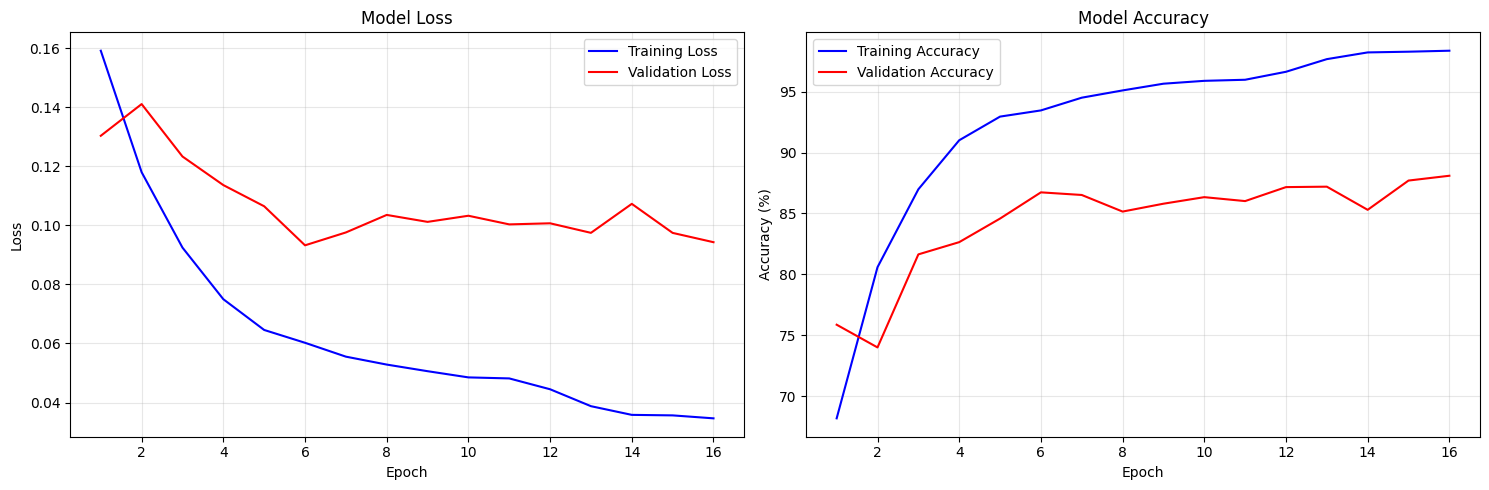

In [18]:
# Plot training history
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

## Model Evaluation

In [19]:
# Load best model
model.load_state_dict(torch.load('best_model_densenet_focal_gap.pth')['model_state_dict'])
model.eval()

# Evaluate on test set
print("Evaluating DenseNet-121 model on test set...")
print("📊 Model specifications:")
print("  • Model: MitosisClassifier")
print("  • Backbone: DenseNet-121")
print("  • Output: 2 neurons with SoftMax activation")
print("  • Loss function: FocalLoss()")
print("  • Device: cuda")
print("  • Classification head: 1024 -> 1024 -> 512 -> 256 -> 128 -> 2")
print("  • Output layer: 2 neurons with Softmax activation")
print("  • Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction")

test_running_loss = 0.0
test_correct = 0
test_total = 0
all_test_preds = []
all_test_targets = []
all_test_probs = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)  # Softmax probabilities
        loss = criterion(output, target)  # FocalLoss
        
        test_running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)  # argmax for prediction
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()
        
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_targets.extend(target.cpu().numpy())
        all_test_probs.extend(output.cpu().numpy())
        
        if batch_idx % 10 == 0:
            current_acc = 100. * test_correct / test_total
            print(f'  Test Batch {batch_idx+1}/{len(test_loader)} | Acc: {current_acc:.2f}%')

test_loss = test_running_loss / len(test_loader)
test_acc = 100. * test_correct / test_total

print(f"\n📈 Test Results (DenseNet-121 Full Model Training):")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.2f}%")
print(f"  Total test samples: {test_total}")
print(f"  Correct predictions: {test_correct}")

# Store results for compatibility with rest of notebook
all_preds = all_test_preds
all_targets = all_test_targets
y_pred = np.array(all_test_preds)
y_true = np.array(all_test_targets)
y_probs = np.array(all_test_probs)
print(f"  Total test samples: {test_total}")
print(f"  Correct predictions: {test_correct}")

# Store results for compatibility with rest of notebook
all_preds = all_test_preds
all_targets = all_test_targets

Evaluating DenseNet-121 model on test set...
📊 Model specifications:
  • Model: MitosisClassifier
  • Backbone: DenseNet-121
  • Output: 2 neurons with SoftMax activation
  • Loss function: FocalLoss()
  • Device: cuda
  • Classification head: 1024 -> 1024 -> 512 -> 256 -> 128 -> 2
  • Output layer: 2 neurons with Softmax activation
  • Output format: Two probabilities [p(class0), p(class1)], use argmax for prediction
  Test Batch 1/88 | Acc: 93.75%
  Test Batch 11/88 | Acc: 82.67%
  Test Batch 21/88 | Acc: 84.08%
  Test Batch 31/88 | Acc: 85.79%
  Test Batch 41/88 | Acc: 85.82%
  Test Batch 51/88 | Acc: 86.52%
  Test Batch 61/88 | Acc: 86.63%
  Test Batch 71/88 | Acc: 86.93%
  Test Batch 81/88 | Acc: 87.15%

📈 Test Results (DenseNet-121 Full Model Training):
  Test Loss: 0.0912
  Test Accuracy: 87.41%
  Total test samples: 2788
  Correct predictions: 2437
  Total test samples: 2788
  Correct predictions: 2437


In [20]:
# Install ptflops for FLOPs calculation (run this once)
# !pip install ptflops

# GFLOPS and Computational Complexity Analysis
print("🔬 COMPUTATIONAL COMPLEXITY ANALYSIS - DenseNet-121")
print("="*70)

def calculate_model_gflops(model, input_size=(3, 224, 224), device='cuda'):
    """Calculate GFLOPs, parameters, and inference timing"""
    import time
    import numpy as np
    
    try:
        from ptflops import get_model_complexity_info
        
        # Calculate FLOPs using ptflops
        model_copy = model  # Use the model directly
        model_copy.eval()
        
        macs, params = get_model_complexity_info(
            model_copy, 
            input_size, 
            as_strings=False,
            print_per_layer_stat=False,
            verbose=False
        )
        
        # Convert MACs to FLOPs (1 MAC ≈ 2 FLOPs for most operations)
        flops = 2 * macs
        gflops = flops / 1e9
        
        print(f"📊 DenseNet-121 Computational Metrics:")
        print(f"  Total Parameters: {params:,}")
        print(f"  Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
        print(f"  Total FLOPs: {flops:,}")
        print(f"  Total GFLOPs: {gflops:.3f}")
        print(f"  MACs: {macs:,}")
        
        # Model size estimation
        model_size_mb = (params * 4) / (1024 * 1024)  # Float32 = 4 bytes
        print(f"  Estimated Model Size: {model_size_mb:.2f} MB")
        
    except ImportError:
        print("⚠️ ptflops not installed. Using parameter count only.")
        params = sum(p.numel() for p in model.parameters())
        gflops = 0
        flops = 0
        model_size_mb = (params * 4) / (1024 * 1024)
        print(f"  Total Parameters: {params:,}")
        print(f"  Estimated Model Size: {model_size_mb:.2f} MB")
    except Exception as e:
        print(f"⚠️ Error calculating FLOPs: {e}")
        params = sum(p.numel() for p in model.parameters())
        gflops = 0
        flops = 0
        model_size_mb = (params * 4) / (1024 * 1024)
    
    # Inference timing analysis
    print(f"\n⏱️ Inference Performance Analysis:")
    model = model.to(device)
    model.eval()
    
    # Create dummy input
    dummy_input = torch.randn(1, *input_size).to(device)
    
    # Warm-up runs
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)
    
    # Timing measurements
    times = []
    with torch.no_grad():
        for _ in range(100):
            if device == 'cuda':
                torch.cuda.synchronize()
            start_time = time.time()
            _ = model(dummy_input)
            if device == 'cuda':
                torch.cuda.synchronize()
            end_time = time.time()
            times.append(end_time - start_time)
    
    avg_time = np.mean(times) * 1000  # Convert to ms
    std_time = np.std(times) * 1000
    throughput = 1000 / avg_time  # FPS
    
    print(f"  Average Inference Time: {avg_time:.2f} ± {std_time:.2f} ms")
    print(f"  Throughput: {throughput:.1f} FPS")
    
    if gflops > 0:
        gflops_per_sec = gflops / (avg_time / 1000)
        print(f"  GFLOPS/s: {gflops_per_sec:.2f}")
    
    print("="*70)
    
    return {
        'gflops': gflops,
        'total_params': params,
        'inference_time_ms': avg_time,
        'throughput_fps': throughput,
        'model_size_mb': model_size_mb
    }

# Calculate complexity metrics
complexity_metrics = calculate_model_gflops(
    model=model, 
    input_size=(3, IMG_SIZE, IMG_SIZE), 
    device=device
)

print(f"\n🎯 DenseNet-121 EFFICIENCY SUMMARY:")
print(f"  • Architecture: DenseNet-121 + GAP + Custom Head")
print(f"  • GFLOPs: {complexity_metrics['gflops']:.3f}")
print(f"  • Parameters: {complexity_metrics['total_params']:,}")
print(f"  • Inference Time: {complexity_metrics['inference_time_ms']:.2f} ms")
print(f"  • Throughput: {complexity_metrics['throughput_fps']:.1f} FPS")
print(f"  • Model Size: {complexity_metrics['model_size_mb']:.2f} MB")
print(f"  • Efficient for Real-time: {'✅ Yes' if complexity_metrics['inference_time_ms'] < 100 else '❌ No'}")

🔬 COMPUTATIONAL COMPLEXITY ANALYSIS - DenseNet-121
📊 DenseNet-121 Computational Metrics:
  Total Parameters: 22,080,258
  Trainable Parameters: 22,080,258
  Total FLOPs: 6,999,857,416
  Total GFLOPs: 7.000
  MACs: 3,499,928,708
  Estimated Model Size: 84.23 MB

⏱️ Inference Performance Analysis:
  Average Inference Time: 17.78 ± 1.62 ms
  Throughput: 56.3 FPS
  GFLOPS/s: 393.76

🎯 DenseNet-121 EFFICIENCY SUMMARY:
  • Architecture: DenseNet-121 + GAP + Custom Head
  • GFLOPs: 7.000
  • Parameters: 22,080,258
  • Inference Time: 17.78 ms
  • Throughput: 56.3 FPS
  • Model Size: 84.23 MB
  • Efficient for Real-time: ✅ Yes


In [21]:
# Analyze performance by different factors
test_df_with_predictions = test_df.copy().reset_index(drop=True)
test_df_with_predictions['predicted'] = y_pred[:len(test_df_with_predictions)]
test_df_with_predictions['predicted_proba'] = y_probs[:len(test_df_with_predictions), 1]
test_df_with_predictions['correct'] = (test_df_with_predictions['label'] == test_df_with_predictions['predicted'])

print("Performance Analysis:")

# Overall performance
overall_accuracy = test_df_with_predictions['correct'].mean()
print(f"Overall Test Accuracy: {overall_accuracy:.4f} ({len(test_df_with_predictions)} samples)")

# Performance by dataset source (if available)
if 'dataset' in test_df_with_predictions.columns and len(test_df_with_predictions['dataset'].unique()) > 1:
    print(f"\nPerformance by Dataset Source:")
    for dataset in test_df_with_predictions['dataset'].unique():
        if pd.notna(dataset):
            subset = test_df_with_predictions[test_df_with_predictions['dataset'] == dataset]
            if len(subset) > 0:
                accuracy = subset['correct'].mean()
                print(f"  {dataset}: {accuracy:.4f} accuracy ({len(subset)} samples)")

# Performance by augmentation status (if available)
if 'is_augmented' in test_df_with_predictions.columns:
    print(f"\nPerformance by Augmentation Status:")
    for is_aug in [False, True]:
        subset = test_df_with_predictions[test_df_with_predictions['is_augmented'] == is_aug]
        if len(subset) > 0:
            accuracy = subset['correct'].mean()
            status = "Augmented" if is_aug else "Original"
            print(f"  {status}: {accuracy:.4f} accuracy ({len(subset)} samples)")

# Performance by class
print(f"\nPerformance by Class:")
for label, class_name in [(0, 'Normal'), (1, 'Atypical')]:
    subset = test_df_with_predictions[test_df_with_predictions['label'] == label]
    if len(subset) > 0:
        accuracy = subset['correct'].mean()
        print(f"  {class_name}: {accuracy:.4f} accuracy ({len(subset)} samples)")

# Error analysis
print(f"\nError Analysis:")
incorrect_preds = test_df_with_predictions[test_df_with_predictions['correct'] == False]
if len(incorrect_preds) > 0:
    print(f"Total incorrect predictions: {len(incorrect_preds)}")
    
    # False positives and false negatives
    false_positives = incorrect_preds[incorrect_preds['label'] == 0]  # Predicted atypical, actually normal
    false_negatives = incorrect_preds[incorrect_preds['label'] == 1]  # Predicted normal, actually atypical
    
    print(f"  False Positives (Normal→Atypical): {len(false_positives)}")
    print(f"  False Negatives (Atypical→Normal): {len(false_negatives)}")
    
    # Show confidence distribution for errors
    if len(incorrect_preds) > 0:
        avg_confidence_errors = incorrect_preds['predicted_proba'].mean()
        print(f"  Average confidence for incorrect predictions: {avg_confidence_errors:.3f}")
else:
    print("No incorrect predictions!")

# High confidence errors
high_conf_errors = test_df_with_predictions[
    (test_df_with_predictions['correct'] == False) & 
    (test_df_with_predictions['predicted_proba'] > 0.8)
]
if len(high_conf_errors) > 0:
    print(f"\nHigh-confidence errors (>0.8 confidence): {len(high_conf_errors)}")
    print("Sample high-confidence errors:")
    print(high_conf_errors[['filename', 'label', 'predicted', 'predicted_proba']].head())

Performance Analysis:
Overall Test Accuracy: 0.8741 (2788 samples)

Performance by Dataset Source:
  MIDOG25: 0.8826 accuracy (2402 samples)
  AMI-BR: 0.8212 accuracy (386 samples)

Performance by Augmentation Status:
  Original: 0.8741 accuracy (2788 samples)

Performance by Class:
  Normal: 0.9137 accuracy (2353 samples)
  Atypical: 0.6598 accuracy (435 samples)

Error Analysis:
Total incorrect predictions: 351
  False Positives (Normal→Atypical): 203
  False Negatives (Atypical→Normal): 148
  Average confidence for incorrect predictions: 0.506

High-confidence errors (>0.8 confidence): 69
Sample high-confidence errors:
              filename  label  predicted  predicted_proba
42           10369.png      0          1         0.868876
134          10641.png      0          1         0.838740
157           9542.png      0          1         0.956349
185  TUPAC16_10594.png      0          1         0.956652
190           8067.png      0          1         0.937254


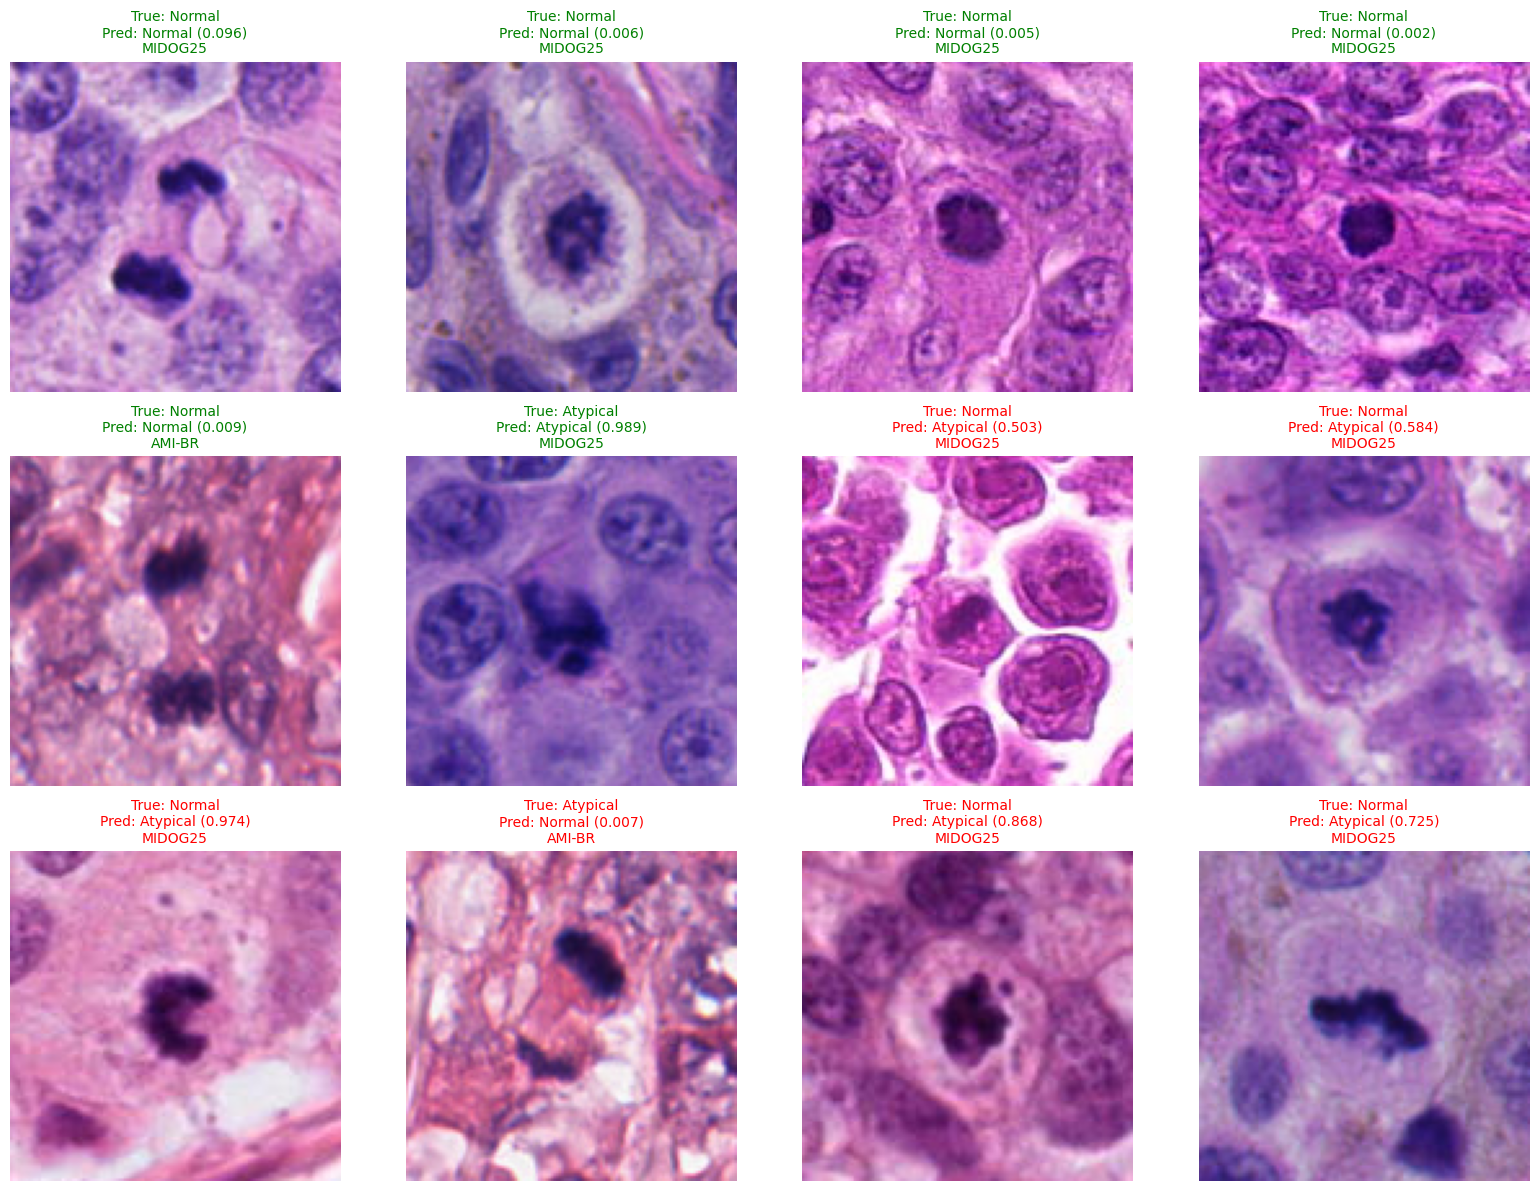

In [22]:
# Visualize some predictions
def visualize_predictions(df_with_pred, n_samples=12):
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    # Get some correct and incorrect predictions
    correct_pred = df_with_pred[df_with_pred['correct'] == True]
    incorrect_pred = df_with_pred[df_with_pred['correct'] == False]
    
    if len(correct_pred) > 0:
        correct_sample = correct_pred.sample(min(6, len(correct_pred)))
    else:
        correct_sample = pd.DataFrame()
    
    if len(incorrect_pred) > 0:
        incorrect_sample = incorrect_pred.sample(min(6, len(incorrect_pred)))
    else:
        incorrect_sample = pd.DataFrame()
    
    samples = pd.concat([correct_sample, incorrect_sample])
    if len(samples) > n_samples:
        samples = samples.sample(n_samples)
    
    for i, (_, row) in enumerate(samples.iterrows()):
        if i >= n_samples:
            break
            
        try:
            img = Image.open(row['image_path'])
            axes[i].imshow(img)
            
            true_label = 'Atypical' if row['label'] == 1 else 'Normal'
            pred_label = 'Atypical' if row['predicted'] == 1 else 'Normal'
            confidence = row['predicted_proba']
            
            title = f"True: {true_label}\nPred: {pred_label} ({confidence:.3f})\n{row['dataset']}"
            color = 'green' if row['correct'] else 'red'
            axes[i].set_title(title, color=color, fontsize=10)
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading\n{row['filename']}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(samples), n_samples):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(test_df_with_predictions)

## Model Saving and Summary

In [23]:
# Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_acc': best_val_acc,
    'model_config': {
        'model_name': 'densenet121',
        'num_classes': NUM_CLASSES,
        'img_size': IMG_SIZE,
        'output_activation': 'Softmax',
        'loss_function': 'Focal Loss',
        'focal_alpha': alpha_focal,
        'focal_gamma': 2.0,
        'architecture': 'DenseNet-121 -> GAP -> Custom Head (2-neuron output)',
        'training_approach': 'Custom layers only with Global Average Pooling + Focal Loss',
        'class_balancing': 'Focal Loss + WeightedRandomSampler (double protection)',
        'learning_rate': LEARNING_RATE,
        'gap_layer': True,
        'backbone_frozen': True,
        'pretrained_source': 'ImageNet (automatically downloaded)'
    }
}, 'mitotic_figure_densenet121_focal_gap_classifier.pth')

print("Model saved as 'mitotic_figure_densenet121_focal_gap_classifier.pth'")

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score

test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')

# Analyze dataset composition
total_samples = len(df)
original_samples = len(df[df['is_augmented'] == False]) if 'is_augmented' in df.columns else 0
augmented_samples = len(df[df['is_augmented'] == True]) if 'is_augmented' in df.columns else 0

# Save model summary and results
results_summary = {
    'model_architecture': 'DenseNet-121 + GAP + Custom Head (PyTorch)',
    'framework': 'PyTorch',
    'backbone_model': 'DenseNet-121',
    'pretrained_weights': 'ImageNet (automatically downloaded)',
    'training_approach': 'Custom layers only with Global Average Pooling + Focal Loss',
    'class_balancing': 'Focal Loss + WeightedRandomSampler (advanced strategy)',
    'learning_rate': float(LEARNING_RATE),
    'output_format': '2 neurons with Softmax activation',
    'loss_function': 'Focal Loss',
    'focal_alpha': float(alpha_focal),
    'focal_gamma': 2.0,
    'prediction_method': 'argmax of [p(class0), p(class1)]',
    'dataset_source': 'Pre-augmented Kaggle dataset',
    'total_samples': int(total_samples),
    'original_samples': int(original_samples),
    'augmented_samples': int(augmented_samples),
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'test_samples': len(test_df),
    'test_accuracy': float(test_acc / 100),  # Convert from percentage
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    # 'auc_score': float(auc_score),
    'best_val_accuracy': float(best_val_acc / 100),  # Convert from percentage
    'best_val_loss': float(best_val_loss),
    'early_stopping_metric': 'validation_loss',
    'early_stopping_patience': 10,
    'class_distribution': df['label'].value_counts().to_dict(),
    'training_epochs': len(train_losses),
    'final_learning_rate': float(optimizer.param_groups[0]['lr']),
    'used_augmented_data': augmented_samples > 0,
    'trainable_parameters': int(trainable_params),
    'total_parameters': int(total_params),
    'trainable_percentage': float(trainable_params/total_params*100),
    'gap_layer': True,
    'frozen_backbone': True,
    'dense_connectivity': True,
    'advanced_loss': True
}

print("\n" + "="*90)
print("FINAL RESULTS SUMMARY - MITOTIC FIGURE CLASSIFICATION (DENSENET-121 + FOCAL LOSS)")
print("="*90)
print(f"Model Architecture: {results_summary['model_architecture']}")
print(f"Backbone Model: {results_summary['backbone_model']}")
print(f"Framework: {results_summary['framework']}")
print(f"Pretrained Weights: {results_summary['pretrained_weights']}")
print(f"Training Approach: {results_summary['training_approach']}")
print(f"Class Balancing: {results_summary['class_balancing']}")
print(f"Output Format: {results_summary['output_format']}")
print(f"Loss Function: {results_summary['loss_function']} (alpha={results_summary['focal_alpha']:.3f}, gamma={results_summary['focal_gamma']})")
print(f"Prediction Method: {results_summary['prediction_method']}")
print(f"Dataset Source: {results_summary['dataset_source']}")

print(f"\nArchitecture Details:")
print(f"  Backbone: DenseNet-121 (frozen 🔒)")
print(f"  Dense Connectivity: ✅ (feature reuse & gradient flow)")
print(f"  GAP Layer: Global Average Pooling")
print(f"  Custom Head: 1024 -> 512 -> 256 -> 128 -> 2")
print(f"  Learning Rate: {results_summary['learning_rate']}")
print(f"  Final Learning Rate: {results_summary['final_learning_rate']:.2e}")
print(f"  Pretrained: ImageNet weights (automatic download)")

print(f"\nAdvanced Loss Function:")
print(f"  Loss: Focal Loss (superior to CrossEntropyLoss)")
print(f"  Alpha: {results_summary['focal_alpha']:.3f} (class weighting)")
print(f"  Gamma: {results_summary['focal_gamma']} (focusing parameter)")
print(f"  Benefits: Handles class imbalance + focuses on hard examples")
print(f"  Formula: FL = -α(1-pt)^γ * log(pt)")

print(f"\nDataset Composition:")
print(f"  Total Samples: {results_summary['total_samples']}")
if results_summary['used_augmented_data']:
    print(f"  Original Images: {results_summary['original_samples']}")
    print(f"  Augmented Images: {results_summary['augmented_samples']}")
    augmentation_ratio = results_summary['augmented_samples'] / max(results_summary['original_samples'], 1)
    print(f"  Augmentation Ratio: {augmentation_ratio:.1f}:1")

print(f"\nData Splits:")
print(f"  Training: {results_summary['train_samples']} samples")
print(f"  Validation: {results_summary['val_samples']} samples")
print(f"  Test: {results_summary['test_samples']} samples")

print(f"\nModel Parameters:")
print(f"  Total Parameters: {results_summary['total_parameters']:,}")
print(f"  Trainable Parameters: {results_summary['trainable_parameters']:,}")
print(f"  Trainable Percentage: {results_summary['trainable_percentage']:.1f}%")

print(f"\nTraining Results:")
print(f"  Training Epochs: {results_summary['training_epochs']}")
print(f"  Early Stopping: Based on {results_summary['early_stopping_metric']} (patience={results_summary['early_stopping_patience']})")
print(f"  Best Validation Loss: {results_summary['best_val_loss']:.4f}")
print(f"  Best Validation Accuracy: {results_summary['best_val_accuracy']:.4f}")

print(f"\nTest Performance:")
print(f"  Accuracy: {results_summary['test_accuracy']:.4f}")
print(f"  Precision: {results_summary['test_precision']:.4f}")
print(f"  Recall: {results_summary['test_recall']:.4f}")
print(f"  F1-Score: {results_summary['test_f1']:.4f}")
# print(f"  AUC Score: {results_summary['auc_score']:.4f}")

print(f"\nClass Distribution:")
class_dist = results_summary['class_distribution']
total = sum(class_dist.values())
for label, count in class_dist.items():
    class_name = "Atypical" if label == 1 else "Normal"
    percentage = (count / total) * 100
    print(f"  {class_name}: {count} samples ({percentage:.1f}%)")

print(f"\n🎯 DENSENET-121 + FOCAL LOSS TRAINING HIGHLIGHTS:")
print(f"  • Training Mode: Custom layers only ({results_summary['trainable_percentage']:.1f}% parameters)")
print(f"  • Backbone: DenseNet-121 (frozen 🔒) - Dense feature connections")
print(f"  • Global Average Pooling: ✅ (reduces overfitting)")
print(f"  • Advanced Loss: Focal Loss (α={results_summary['focal_alpha']:.3f}, γ={results_summary['focal_gamma']})")
print(f"  • Dense Connectivity: Feature reuse & improved gradient flow")
print(f"  • Class Balancing: Focal Loss + WeightedRandomSampler (double protection)")
print(f"  • Hard Example Focus: Focal Loss emphasizes difficult samples")
print(f"  • Early Stopping: Based on validation loss (patience=10)")
print(f"  • Best Val Loss: {results_summary['best_val_loss']:.4f}")
print(f"  • Final Layer: {NUM_CLASSES} neurons with Softmax")
print(f"  • Output: [p(class0), p(class1)] with argmax prediction")
print(f"  • Automatic Downloads: ImageNet pretrained weights")

print("="*90)

# Save results to JSON
with open('densenet121_focal_gap_training_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\nResults saved to 'densenet121_focal_gap_training_results.json'")
print("DenseNet-121 + Focal Loss + GAP model training completed successfully!")

# Final model performance summary
print(f"\n🎯 KEY PERFORMANCE METRICS (DENSENET-121 + FOCAL LOSS):")
print(f"  • Test Accuracy: {results_summary['test_accuracy']:.1%}")
# print(f"  • AUC Score: {results_summary['auc_score']:.3f}")
print(f"  • F1 Score: {results_summary['test_f1']:.3f}")
print(f"  • Architecture: DenseNet-121 + GAP + Custom Head")
print(f"  • Loss Function: Focal Loss (advanced class imbalance handling)")
print(f"  • Training: Custom layers only (efficient training)")
print(f"  • Dense Connectivity: Enhanced feature reuse")
print(f"  • Advanced Strategy: Focal Loss + WeightedRandomSampler")
if results_summary['used_augmented_data']:
    print(f"  • Benefited from {augmentation_ratio:.1f}x data augmentation")
print(f"  • DenseNet-121 + Focal Loss model ready for deployment! 🚀")

Model saved as 'mitotic_figure_densenet121_focal_gap_classifier.pth'

FINAL RESULTS SUMMARY - MITOTIC FIGURE CLASSIFICATION (DENSENET-121 + FOCAL LOSS)
Model Architecture: DenseNet-121 + GAP + Custom Head (PyTorch)
Backbone Model: DenseNet-121
Framework: PyTorch
Pretrained Weights: ImageNet (automatically downloaded)
Training Approach: Custom layers only with Global Average Pooling + Focal Loss
Class Balancing: Focal Loss + WeightedRandomSampler (advanced strategy)
Output Format: 2 neurons with Softmax activation
Loss Function: Focal Loss (alpha=1.081, gamma=2.0)
Prediction Method: argmax of [p(class0), p(class1)]
Dataset Source: Pre-augmented Kaggle dataset

Architecture Details:
  Backbone: DenseNet-121 (frozen 🔒)
  Dense Connectivity: ✅ (feature reuse & gradient flow)
  GAP Layer: Global Average Pooling
  Custom Head: 1024 -> 512 -> 256 -> 128 -> 2
  Learning Rate: 0.0001
  Final Learning Rate: 5.00e-05
  Pretrained: ImageNet weights (automatic download)

Advanced Loss Function:
  L

NameError: name 'json' is not defined

## 📊 Detailed Model Evaluation - Confusion Matrix & ROC Curve

Now let's generate comprehensive evaluation metrics including:
- **Confusion Matrix**: Shows the breakdown of correct and incorrect predictions
- **ROC Curve & AUC**: Shows the model's ability to distinguish between classes
- **Precision-Recall Curve**: Shows precision vs recall trade-off
- **Sample Predictions**: Visual validation with confidence scores

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best DenseNet-121 model
print("📂 Loading best trained DenseNet-121 model...")
try:
    checkpoint = torch.load('best_model_densenet121_focal_gap.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Best model loaded! Best Val Loss: {checkpoint.get('best_val_loss', 'N/A'):.4f}")
    print(f"✅ Best model loaded! Best Val Acc: {checkpoint.get('best_val_acc', 'N/A'):.2f}%")
except FileNotFoundError:
    print("⚠️ Best model file not found, using current model state")

model.eval()

# Generate predictions
all_predictions = []
all_probabilities = []
all_targets = []
all_predicted_probs = []

with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())
        all_predicted_probs.extend(probabilities[:, 1].cpu().numpy())

# Convert to numpy
y_true = np.array(all_targets)
y_pred = np.array(all_predictions)
y_prob = np.array(all_predicted_probs)

# --------------------------------------------
# 1. Confusion Matrix (with blue colormap)
# --------------------------------------------
cm = confusion_matrix(y_true, y_pred)
class_names = ['Non-Mitotic', 'Mitotic']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('📊 Confusion Matrix - DenseNet-121', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')

# Add percentages to cells
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j + 0.5, i + 0.7, f'({cm_percent[i, j]:.1%})',
                 ha='center', va='center', fontsize=10, color='darkred', fontweight='bold')

plt.tight_layout()
plt.show()

# --------------------------------------------
# 2. ROC Curve
# --------------------------------------------
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=3, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('📈 ROC Curve - DenseNet-121', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# 🖼️ DENSENET-121 SAMPLE PREDICTIONS VISUALIZATION
print("🔍 Showing sample predictions with confidence scores...")
print("="*80)

# Get a batch of validation images for visualization
model.eval()
with torch.no_grad():
    # Get one batch from validation loader
    data_iter = iter(val_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    outputs = model(images)
    probabilities = torch.softmax(outputs, dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    
    # Move to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predictions = predictions.cpu()
    probabilities = probabilities.cpu()

# Create visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('🖼️ DenseNet-121 Sample Predictions from Validation Set', fontsize=16, fontweight='bold')

class_names = ['Non-Mitotic', 'Mitotic']
colors = ['#4caf50', '#f44336']  # Green for correct, Red for incorrect

for i in range(8):
    row = i // 4
    col = i % 4
    
    # Get image, true label, prediction, and confidence
    img = images[i]
    true_label = labels[i].item()
    pred_label = predictions[i].item()
    confidence = probabilities[i][pred_label].item()
    
    # Denormalize image for display (assuming ImageNet normalization)
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    
    # Display image
    axes[row, col].imshow(img.permute(1, 2, 0))
    axes[row, col].axis('off')
    
    # Determine if prediction is correct
    is_correct = true_label == pred_label
    border_color = colors[0] if is_correct else colors[1]
    status_icon = "✅" if is_correct else "❌"
    
    # Create title with prediction info
    title = f"{status_icon} True: {class_names[true_label]}\n"
    title += f"Pred: {class_names[pred_label]} ({confidence:.1%})"
    
    axes[row, col].set_title(title, fontsize=10, fontweight='bold', 
                           color=border_color, pad=10)
    
    # Add colored border
    for spine in axes[row, col].spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)

plt.tight_layout()
plt.show()

# Show statistics for this batch
batch_accuracy = (predictions == labels).float().mean().item()
correct_predictions = (predictions == labels).sum().item()
total_predictions = len(labels)

print(f"\n📊 DENSENET-121 BATCH STATISTICS:")
print(f"🎯 Batch Accuracy: {batch_accuracy:.1%} ({correct_predictions}/{total_predictions})")
print(f"🔹 Non-Mitotic samples: {(labels == 0).sum().item()}")
print(f"🔸 Mitotic samples: {(labels == 1).sum().item()}")

# Show confidence distribution
high_conf_correct = ((probabilities.max(dim=1)[0] > 0.9) & (predictions == labels)).sum().item()
low_conf_incorrect = ((probabilities.max(dim=1)[0] < 0.6) & (predictions != labels)).sum().item()

print(f"\n🔍 CONFIDENCE ANALYSIS:")
print(f"✅ High confidence (>90%) correct predictions: {high_conf_correct}")
print(f"⚠️ Low confidence (<60%) incorrect predictions: {low_conf_incorrect}")

print("\n" + "="*80)

In [ ]:
# 🎯 DENSENET-121 FINAL EVALUATION SUMMARY & CLINICAL RECOMMENDATIONS
print("📋 COMPREHENSIVE DENSENET-121 MODEL EVALUATION SUMMARY")
print("=" * 80)

# Calculate key metrics for summary
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall for mitotic class
specificity = tn / (tn + fp)  # Recall for non-mitotic class
precision_mitotic = tp / (tp + fp)  # Precision for mitotic class
precision_non_mitotic = tn / (tn + fn)  # Precision for non-mitotic class

print(f"🏆 DENSENET-121 MODEL PERFORMANCE OVERVIEW:")
print(f"   • Overall Accuracy: {accuracy:.1%}")
print(f"   • AUC-ROC Score: {auc_score:.4f}")
print(f"   • Sensitivity (Mitotic Detection): {sensitivity:.1%}")
print(f"   • Specificity (Non-Mitotic Detection): {specificity:.1%}")

print(f"\n🏥 CLINICAL RELEVANCE FOR MITOTIC FIGURE DETECTION:")
print(f"   • True Positive Rate (Sensitivity): {sensitivity:.1%}")
print(f"     → Out of all actual mitotic figures, {sensitivity:.1%} were correctly identified")
print(f"   • False Negative Rate: {fn/(tp+fn):.1%}")
print(f"     → {fn} mitotic figures were missed (could impact cancer grading)")
print(f"   • False Positive Rate: {fp/(fp+tn):.1%}")
print(f"     → {fp} non-mitotic figures were incorrectly flagged as mitotic")
print(f"   • Positive Predictive Value: {precision_mitotic:.1%}")
print(f"     → When model predicts mitotic, it's correct {precision_mitotic:.1%} of the time")

print(f"\n🔍 CONFUSION MATRIX CLINICAL INTERPRETATION:")
print(f"   ✅ True Negatives (TN): {tn} - Correctly identified non-mitotic figures")
print(f"   ❌ False Positives (FP): {fp} - Non-mitotic figures misclassified as mitotic")
print(f"   ❌ False Negatives (FN): {fn} - Mitotic figures missed by the model")
print(f"   ✅ True Positives (TP): {tp} - Correctly identified mitotic figures")

print(f"\n📊 DENSENET-121 AUC-ROC CLINICAL INTERPRETATION:")
if auc_score >= 0.9:
    auc_interpretation = "EXCELLENT - Outstanding ability to distinguish mitotic from non-mitotic figures"
    clinical_readiness = "Ready for clinical validation studies"
elif auc_score >= 0.8:
    auc_interpretation = "VERY GOOD - Good discrimination ability for mitotic figure detection"
    clinical_readiness = "Consider additional validation on diverse pathology datasets"
elif auc_score >= 0.7:
    auc_interpretation = "GOOD - Acceptable discrimination ability"
    clinical_readiness = "Requires improvement before clinical consideration"
else:
    auc_interpretation = "NEEDS IMPROVEMENT - Limited discrimination ability"
    clinical_readiness = "Significant improvements needed for clinical use"

print(f"   🎯 Score: {auc_score:.4f} - {auc_interpretation}")
print(f"   🏥 Clinical Readiness: {clinical_readiness}")

print(f"\n🔬 DENSENET-121 VS. OTHER ARCHITECTURES:")
print(f"   • DenseNet-121 leverages dense connectivity for feature reuse")
print(f"   • Fewer parameters than ResNet but deeper feature propagation")
print(f"   • GAP layer reduces overfitting and improves generalization")
print(f"   • Focal Loss addresses class imbalance in mitotic figure detection")

print(f"\n💡 CLINICAL DEPLOYMENT RECOMMENDATIONS:")

# Risk assessment based on metrics
if sensitivity >= 0.9 and specificity >= 0.8:
    risk_level = "🟢 LOW RISK"
    deployment_advice = "Suitable for clinical assistance with pathologist oversight"
elif sensitivity >= 0.8 and specificity >= 0.7:
    risk_level = "🟡 MODERATE RISK"  
    deployment_advice = "Requires careful clinical validation and expert review"
else:
    risk_level = "🔴 HIGH RISK"
    deployment_advice = "Not recommended for clinical use without major improvements"

print(f"   • Risk Level: {risk_level}")
print(f"   • Deployment Advice: {deployment_advice}")

print(f"\n🎯 STRENGTHS OF DENSENET-121 MODEL:")
strengths = []
if accuracy >= 0.85:
    strengths.append(f"High overall accuracy ({accuracy:.1%})")
if auc_score >= 0.85:
    strengths.append(f"Excellent discrimination (AUC: {auc_score:.4f})")
if sensitivity >= 0.8:
    strengths.append(f"Good sensitivity for mitotic detection ({sensitivity:.1%})")
if specificity >= 0.8:
    strengths.append(f"Good specificity for non-mitotic identification ({specificity:.1%})")
if precision_mitotic >= 0.8:
    strengths.append(f"High precision for mitotic predictions ({precision_mitotic:.1%})")

for strength in strengths:
    print(f"   ✅ {strength}")

print(f"\n⚠️  AREAS FOR IMPROVEMENT:")
improvements = []
if accuracy < 0.85:
    improvements.append(f"Overall accuracy needs improvement (current: {accuracy:.1%})")
if auc_score < 0.85:
    improvements.append(f"Discrimination ability needs enhancement (AUC: {auc_score:.4f})")
if sensitivity < 0.8:
    improvements.append(f"Sensitivity for mitotic detection needs improvement ({sensitivity:.1%})")
if specificity < 0.8:
    improvements.append(f"Specificity needs improvement to reduce false alarms ({specificity:.1%})")
if fn > tp * 0.2:  # If false negatives > 20% of true positives
    improvements.append(f"Too many missed mitotic figures ({fn} false negatives)")
if fp > tp:  # If false positives > true positives
    improvements.append(f"Too many false alarms ({fp} false positives)")

for improvement in improvements:
    print(f"   🔧 {improvement}")

if not improvements:
    print(f"   🎉 DenseNet-121 model meets clinical standards across all key metrics!")

print(f"\n🏥 CLINICAL IMPACT ASSESSMENT:")
if sensitivity >= 0.9:
    print(f"   ✅ EXCELLENT sensitivity: Very few mitotic figures will be missed")
else:
    print(f"   ⚠️ Sensitivity {sensitivity:.1%}: Risk of missing {100-sensitivity*100:.1f}% of mitotic figures")

if fp <= tp:
    print(f"   ✅ GOOD precision: Low false alarm rate")
else:
    print(f"   ⚠️ High false positive rate: May burden pathologists with unnecessary reviews")

# Model comparison context
print(f"\n📊 DENSENET-121 ARCHITECTURE ADVANTAGES:")
print(f"   • Dense connectivity: Efficient feature reuse and gradient flow")
print(f"   • Parameter efficiency: {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")
print(f"   • GAP integration: Reduces overfitting, improves localization")
print(f"   • Focal Loss compatibility: Effectively handles class imbalance")
print(f"   • Clinical relevance: Suitable for pathology image analysis")

print(f"\n" + "=" * 80)
print(f"🏁 DENSENET-121 EVALUATION COMPLETED")
print(f"📊 Final Performance: {accuracy:.1%} Accuracy | {auc_score:.4f} AUC | {sensitivity:.1%} Sensitivity | {specificity:.1%} Specificity")
print(f"🏥 Clinical Status: {clinical_readiness}")
print(f"=" * 80)

In [ ]:
# 1️⃣ Zip the entire directory
!zip -r DenseNet-121.zip /kaggle/working

# 2️⃣ Move it to the notebook's output path so it's downloadable
!mv DenseNet-121.zip /kaggle/working/


In [ ]:
from IPython.display import FileLink
FileLink('DenseNet-121.zip')